In [463]:
import numpy as np
import random
from matplotlib.pyplot import imshow
from functools import partial
import matplotlib.pyplot as plt

from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import Callback
from keras.losses import mean_squared_error
from keras import backend as K
from keras import optimizers

import cv2

%matplotlib inline

Указываем глобальные переменные:
- `SEED`: для случайных генераторов с целью воспроизводимости
- `MODE`: режим работы с картинкой **RGB**/**L** - цветной/черно-белый
- `S`: количество аргументов на пиксель (**3** - для цветного изображения, **1** - для черно-белого)
- `IMG_PATH`: путь к обрабатываемому изображению

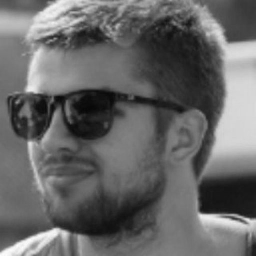

In [315]:
SEED = 342323425
np.random.seed(SEED)
MODE = 'L'
S = 1
CROP = 16
SIZE = 256
IMG_PATH = './img.jpg'
img = Image.open(IMG_PATH)
img = img.resize((SIZE, SIZE))
img.convert(MODE)

Метод загрузки картинки и преобразования в необходимый режим и размер

In [316]:
def load_image(path):
    img = cv2.imread(path, 0)
    img = cv2.resize(img, (SIZE, SIZE))
    return img

In [317]:
IM = load_image(IMG_PATH)
print(IM)
print(IM.shape)

[[ 88  87  86 ...  60  59  59]
 [ 89  88  87 ...  59  59  59]
 [ 91  90  89 ...  59  58  58]
 ...
 [220 226 238 ...  31  32  32]
 [238 241 248 ...  31  32  30]
 [251 247 248 ...  32  32  30]]
(256, 256)


Инициализация гиперпараметров: 
- `W`: ширина картинки
- `H`: высота картинки
- `crop_size`: размер нарезаемого блока
- `L`: количество нарезанных блоков
- `N`: размер вектора, конвертируемого из нарезанного блока

In [318]:
def init_hyperparams(im):
    assert im.shape == (SIZE, SIZE)
    L = SIZE // CROP * SIZE // CROP
    N = CROP * CROP * S
    return SIZE, CROP, L, N, S

pic = load_image(IMG_PATH)
_, _, L, N, S = init_hyperparams(pic)
print(SIZE, L, N, S)

256 256 256 1


Методы преобразования картинки, генераторы нарезаемых блоков. Картинка равномерно нарезается на блоки последовательно слева-направо и сверху-вниз на размеры nxm. При декодировании следует помнить о том, что в результате должны получиться
- целый знчения
- числа в пределах $[0..255]$

Поэтому делается `np.clip(np.int_(C_MAX * (area + 1.0) / 2.0), 0, 255)`

In [319]:
def transform_image(img):
    C_MAX = 255.0
    return 2.0 * img.reshape([SIZE, SIZE // CROP, CROP]).transpose(1, 0, 2).reshape((SIZE // CROP) ** 2, CROP, CROP) / C_MAX - 1.0

g = transform_image(load_image(IMG_PATH))
print(g.shape)

(256, 16, 16)


Подсчет коэффициента сжатия

In [320]:
def get_Z(N, L, p):
    return ((N + L) * p + 2.0) / (N * L)

Логика автокодировщика. Здесь используется метод инициализации весов `glorot_uniform` (https://keras.io/initializers/#glorot_uniform and http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf). На вход можно подавать следующие параметры:
- `input_layers`: количество нейронов на входном слое (равно размеру вектора, вычисляемого из нарезанного блока)
- `lr`: learning rate
- `dynamic_lr`: флаг, отвечающий за динамический пересчет learning rate после каждой итерации, либо использовать переданное значение 
- `z`: коэффициент сжатия. Из него вычисляется количество нейронов на втором слое (`int(z * input_layers)`)
- `w_norm`: флаг, отвечающий за нормировку весов после каждой итерации

Вызов автокодировщика прогоняет все блоки картинки (выполняет одну эпоху). Каждую эпоху насчитывается суммарная ошибка на всех обработанных блоках.

In [491]:
class TrackStatus(Callback):
    
    def __init__(self, encoder, img):
        self.encoder = encoder
        self.img = img
    
    def on_epoch_end(self, epoch, logs={}):
        y = self.encoder.run_compression(self.img)
        current_error = np.linalg.norm(self.img - y)
        print('Epoch: {} Error: {}'.format(epoch, current_error))
        self.encoder.results['min_err'] = np.min([self.encoder.results.get('min_err', 100000000000.0), current_error])
        self.encoder.results['epoch'] = epoch + 1

        if current_error < self.encoder.min_error:
            self.model.stop_training = True
    
    def on_train_begin(self, logs={}):
        pass
        print('Train begin', logs)
    
    def on_train_end(self, logs={}):
        pass
        print('Train End', logs)


class Autoencoder(object):
    
    def __init__(self, input_layers=N, lr=1e-3, dynamic_lr=True, z=0.9, max_epochs=1000, min_error=1000.0):
        self.input_layers = input_layers
        self.mid_layers = int(z * input_layers)
        self.initializer = glorot_uniform(self.input_layers, self.mid_layers)
        self.lr = lr
        self.dynamic_lr = dynamic_lr
        self.max_epochs = max_epochs
        self.min_error = min_error
        self.results = {}
        self.build()

    def build(self):
        input_img = Input(shape=[self.input_layers])
        encoded = Dense(self.mid_layers, activation='linear', kernel_initializer='glorot_uniform')(input_img)
        decoded = Dense(self.input_layers, activation='linear', kernel_initializer='glorot_uniform')(encoded)

        self.autoencoder = Model(input_img, decoded)
        self.optimizer = optimizers.Adam(lr=self.lr)
        
#         if self.dynamic_lr:
# #             self.optimizer = 'adam'
# #             self.optimizer = 'sgd'
#             self.optimizer = optimizers.SGD(decay=0.1)
#         else:
#             self.optimizer = optimizers.SGD(lr=self.lr, decay=0.1)
# #             self.optimizer = optimizers.Adam(lr=self.lr, beta_1=0.9, beta_2=0.999,
# #                                              epsilon=None, decay=0.0, amsgrad=False)
        self.autoencoder.compile(optimizer=self.optimizer, loss=mean_squared_error)
    
    def __call__(self, img, pbar=None):
        X = self.map_X(img)
        callbacks = [TrackStatus(self, img)]
        history = self.autoencoder.fit(X, X, epochs=self.max_epochs,
                                           batch_size=self.input_layers // self.mid_layers,
                                           shuffle=True, validation_split=0.2, verbose=-1,
                                           callbacks=callbacks)
#         return history.history['loss']
        return history
    
    def map_X(self, img):
        tr_img = transform_image(img)
        return np.asarray(list(map(lambda x: np.expand_dims(x.flatten(), 0), tr_img))).reshape((self.input_layers, -1)).T
    
    def run_compression(self, img):
        X = self.map_X(img)
        y = self.autoencoder.predict(X)
        y = (y.T.reshape(-1, CROP, CROP).reshape(SIZE // CROP, SIZE, CROP).transpose(1, 0, 2).reshape(SIZE, SIZE) + 1.0) * 255 / 2
        return np.clip(y, 0, 255)

Метод для запуска обучения для выбранной модели. Контролируются следующие параметры:
- `model`: настроенная модель
- `epochs`: ограничение сверху на количество запускаемых эпох
- `name`: используется для отрисовки названия графика "Количество эпох на ошибку"
- `th_err`: пороговое значение для ошибки
- `viz`: флаг, нужно ли рисовать график
- `ax`: переданный объект plot, на котором нужно рисовать график (следует передать `viz=True`)
- `gen`: генератор для блоков. По умолчанию генерируются блоки из стандартной картинки размера `n x m`
- `progress`: progress bar для визуализации прогресса
- `L`: количество блоков (используется для progress bar по умолчанию)

Критерий останова: ошибка меньше пороговой либо количество запущенных эпох достигло значения `epochs`. В результат сохраняется следующая информация:

- `W1`, `W2`: веса на первом и втором слое соответственно
- `min_err`: минимальная достигнутая ошибка
- `epoch`: количество прошедших эпох (может быть меньше, чем `epochs`, если была получена ошибка меньше заявленной пороговой, но не может быть больше `epochs`)

In [492]:
def try_run(model, img=load_image(IMG_PATH), viz=True):
    history = model(img)
    err = history.history['loss']
    
    if viz:
        plt.plot(range(len(err)), err, linewidth=0.5, markersize=3)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

        res = model.run_compression(img)
        fig, ax = plt.subplots(1, 2, figsize=(16, 16))
        ax[0].imshow(img, cmap='gray')
        ax[0].set_xlabel('original')
        ax[1].imshow(res, cmap='gray')
        ax[1].set_xlabel('modified')
        plt.show()
    
    return model.results

Train on 204 samples, validate on 52 samples
Train begin {}
Epoch 1/200
Epoch: 0 Error: 6401.169921875
Epoch 2/200
Epoch: 1 Error: 5194.41259765625
Epoch 3/200
Epoch: 2 Error: 4188.77099609375
Epoch 4/200
Epoch: 3 Error: 3846.9736328125
Epoch 5/200
Epoch: 4 Error: 3733.163818359375
Epoch 6/200
Epoch: 5 Error: 3522.800537109375
Epoch 7/200
Epoch: 6 Error: 3402.865966796875
Epoch 8/200
Epoch: 7 Error: 3240.17333984375
Epoch 9/200
Epoch: 8 Error: 3145.381103515625
Epoch 10/200
Epoch: 9 Error: 3023.60546875
Epoch 11/200
Epoch: 10 Error: 2942.703857421875
Epoch 12/200
Epoch: 11 Error: 2851.4951171875
Epoch 13/200
Epoch: 12 Error: 2815.855224609375
Epoch 14/200
Epoch: 13 Error: 2758.93505859375
Epoch 15/200
Epoch: 14 Error: 2720.11181640625
Epoch 16/200
Epoch: 15 Error: 2680.868408203125
Epoch 17/200
Epoch: 16 Error: 2642.647216796875
Epoch 18/200
Epoch: 17 Error: 2573.017822265625
Epoch 19/200
Epoch: 18 Error: 2564.65771484375
Epoch 20/200
Epoch: 19 Error: 2498.4814453125
Epoch 21/200
Epoch

Epoch: 168 Error: 1465.6068115234375
Epoch 170/200
Epoch: 169 Error: 1468.9029541015625
Epoch 171/200
Epoch: 170 Error: 1464.9771728515625
Epoch 172/200
Epoch: 171 Error: 1447.648681640625
Epoch 173/200
Epoch: 172 Error: 1464.777587890625
Epoch 174/200
Epoch: 173 Error: 1452.818603515625
Epoch 175/200
Epoch: 174 Error: 1468.6353759765625
Epoch 176/200
Epoch: 175 Error: 1457.682373046875
Epoch 177/200
Epoch: 176 Error: 1461.4984130859375
Epoch 178/200
Epoch: 177 Error: 1450.6998291015625
Epoch 179/200
Epoch: 178 Error: 1447.7738037109375
Epoch 180/200
Epoch: 179 Error: 1457.4111328125
Epoch 181/200
Epoch: 180 Error: 1456.18017578125
Epoch 182/200
Epoch: 181 Error: 1435.0771484375
Epoch 183/200
Epoch: 182 Error: 1467.0633544921875
Epoch 184/200
Epoch: 183 Error: 1428.8782958984375
Epoch 185/200
Epoch: 184 Error: 1435.86279296875
Epoch 186/200
Epoch: 185 Error: 1425.1905517578125
Epoch 187/200
Epoch: 186 Error: 1442.943115234375
Epoch 188/200
Epoch: 187 Error: 1426.9930419921875
Epoch 189

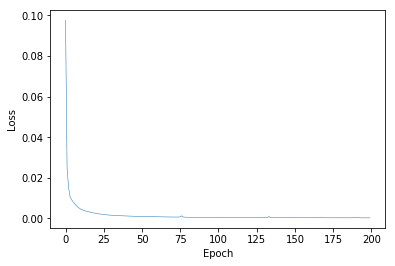

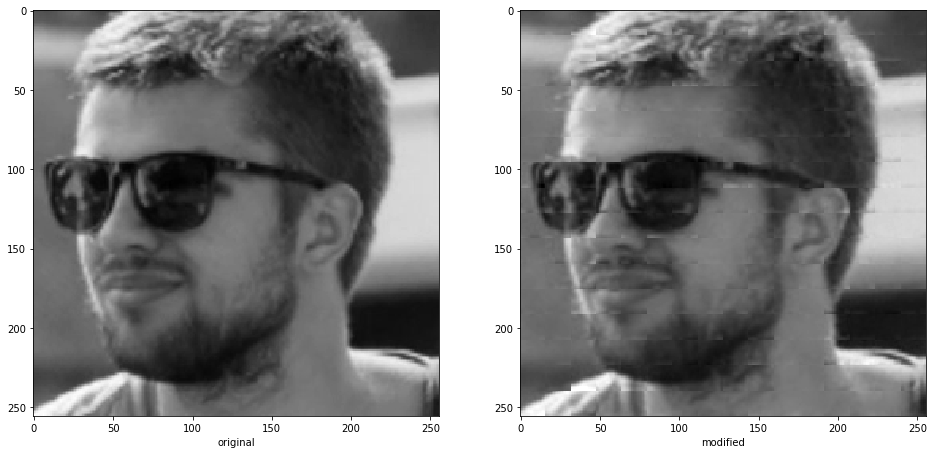

{'min_err': 1400.684814453125, 'epoch': 200}

In [499]:
model = Autoencoder(input_layers=N, z=0.2, max_epochs=200, min_error=100.0)
try_run(model)

Зависимость количества эпох от коэффициента сжатия `Z`. Фиксированные параметры:
- `th_err`: 10.0
- `epochs`: 3000
- `dynamic_lr`: True

running for z=0.95
Train on 204 samples, validate on 52 samples
Train begin {}
Epoch 1/200
Epoch: 0 Error: 3565.461181640625
Epoch 2/200
Epoch: 1 Error: 2833.5244140625
Epoch 3/200
Epoch: 2 Error: 3172.16552734375
Epoch 4/200
Epoch: 3 Error: 2442.17529296875
Epoch 5/200
Epoch: 4 Error: 2437.01904296875
Epoch 6/200
Epoch: 5 Error: 2256.762939453125
Epoch 7/200
Epoch: 6 Error: 2313.668212890625
Epoch 8/200
Epoch: 7 Error: 2280.1728515625
Epoch 9/200
Epoch: 8 Error: 2160.439453125
Epoch 10/200
Epoch: 9 Error: 2014.012939453125
Epoch 11/200
Epoch: 10 Error: 2072.98828125
Epoch 12/200
Epoch: 11 Error: 2056.801025390625
Epoch 13/200
Epoch: 12 Error: 1883.252685546875
Train End {}


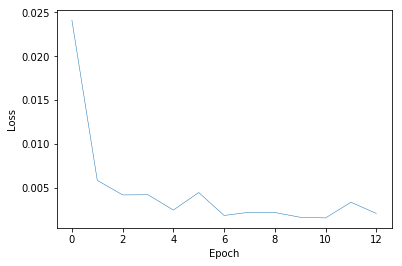

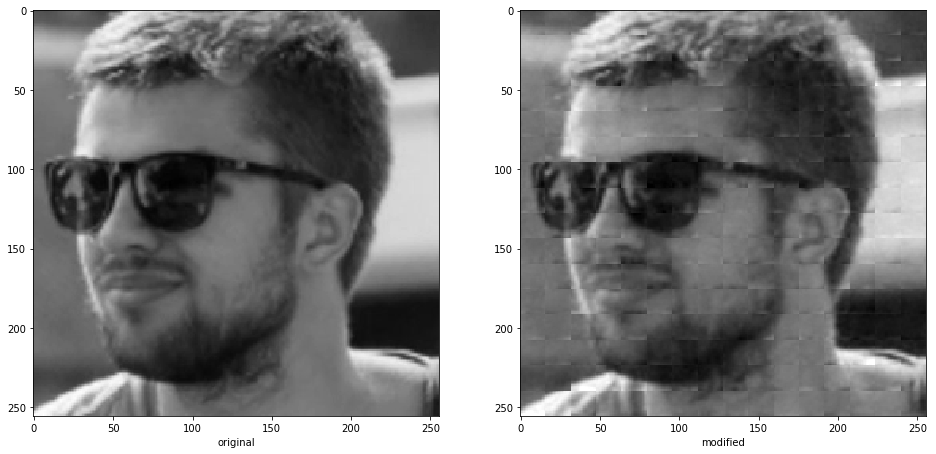

Error: 1883.252685546875
running for z=0.85
Train on 204 samples, validate on 52 samples
Train begin {}
Epoch 1/200
Epoch: 0 Error: 3562.485595703125
Epoch 2/200
Epoch: 1 Error: 3000.836669921875
Epoch 3/200
Epoch: 2 Error: 2860.97607421875
Epoch 4/200
Epoch: 3 Error: 2547.244873046875
Epoch 5/200
Epoch: 4 Error: 2859.78515625
Epoch 6/200
Epoch: 5 Error: 2402.90625
Epoch 7/200
Epoch: 6 Error: 2211.8017578125
Epoch 8/200
Epoch: 7 Error: 2156.23828125
Epoch 9/200
Epoch: 8 Error: 2168.88916015625
Epoch 10/200
Epoch: 9 Error: 2189.14111328125
Epoch 11/200
Epoch: 10 Error: 2211.29931640625
Epoch 12/200
Epoch: 11 Error: 1892.9918212890625
Train End {}


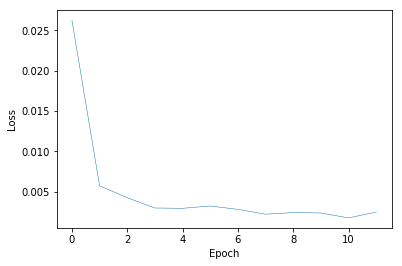

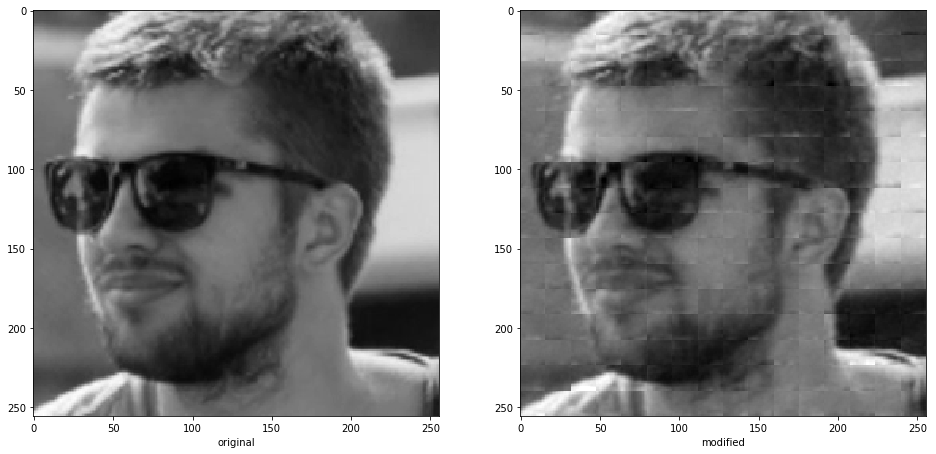

Error: 1892.9918212890625
running for z=0.75
Train on 204 samples, validate on 52 samples
Train begin {}
Epoch 1/200
Epoch: 0 Error: 3619.627685546875
Epoch 2/200
Epoch: 1 Error: 2940.03759765625
Epoch 3/200
Epoch: 2 Error: 2688.26318359375
Epoch 4/200
Epoch: 3 Error: 2586.708251953125
Epoch 5/200
Epoch: 4 Error: 2595.5234375
Epoch 6/200
Epoch: 5 Error: 2214.76904296875
Epoch 7/200
Epoch: 6 Error: 2240.89404296875
Epoch 8/200
Epoch: 7 Error: 2659.78955078125
Epoch 9/200
Epoch: 8 Error: 2562.2099609375
Epoch 10/200
Epoch: 9 Error: 1962.116943359375
Train End {}


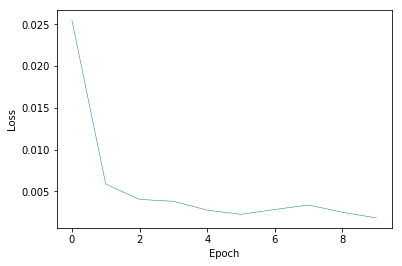

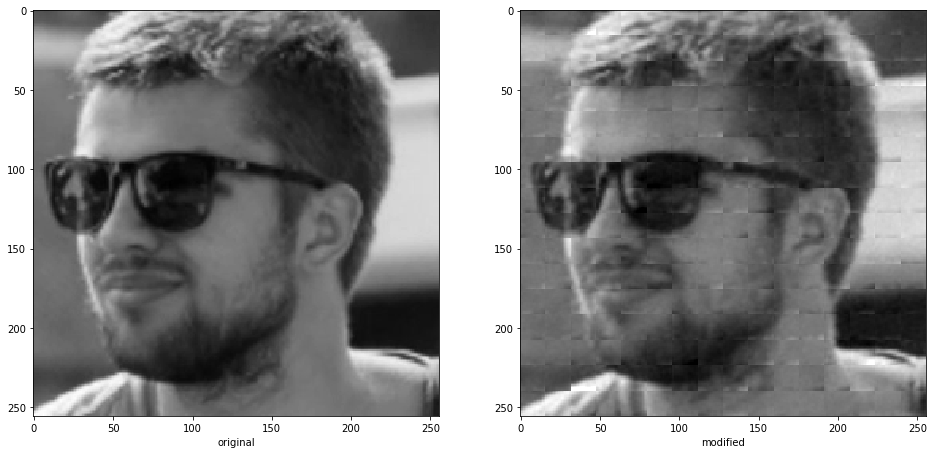

Error: 1962.116943359375
running for z=0.65
Train on 204 samples, validate on 52 samples
Train begin {}
Epoch 1/200
Epoch: 0 Error: 3758.741455078125
Epoch 2/200
Epoch: 1 Error: 3073.343505859375
Epoch 3/200
Epoch: 2 Error: 2728.246337890625
Epoch 4/200
Epoch: 3 Error: 2621.518798828125
Epoch 5/200
Epoch: 4 Error: 2453.058837890625
Epoch 6/200
Epoch: 5 Error: 2417.756103515625
Epoch 7/200
Epoch: 6 Error: 2191.3994140625
Epoch 8/200
Epoch: 7 Error: 2289.4580078125
Epoch 9/200
Epoch: 8 Error: 2172.690673828125
Epoch 10/200
Epoch: 9 Error: 2137.69287109375
Epoch 11/200
Epoch: 10 Error: 2069.024658203125
Epoch 12/200
Epoch: 11 Error: 2013.7406005859375
Epoch 13/200
Epoch: 12 Error: 2041.2745361328125
Epoch 14/200
Epoch: 13 Error: 1825.817626953125
Train End {}


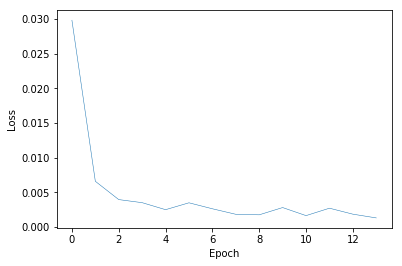

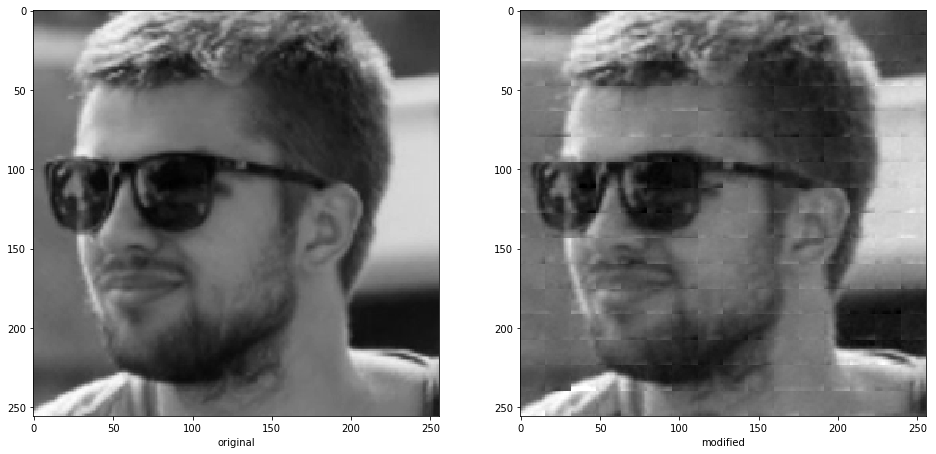

Error: 1825.817626953125
running for z=0.5499999999999999
Train on 204 samples, validate on 52 samples
Train begin {}
Epoch 1/200
Epoch: 0 Error: 4000.427490234375
Epoch 2/200
Epoch: 1 Error: 3171.015625
Epoch 3/200
Epoch: 2 Error: 2718.0302734375
Epoch 4/200
Epoch: 3 Error: 2524.2509765625
Epoch 5/200
Epoch: 4 Error: 2526.382080078125
Epoch 6/200
Epoch: 5 Error: 2313.3369140625
Epoch 7/200
Epoch: 6 Error: 2172.9296875
Epoch 8/200
Epoch: 7 Error: 2140.165283203125
Epoch 9/200
Epoch: 8 Error: 2177.051025390625
Epoch 10/200
Epoch: 9 Error: 2145.413818359375
Epoch 11/200
Epoch: 10 Error: 2351.0478515625
Epoch 12/200
Epoch: 11 Error: 1999.9412841796875
Train End {}


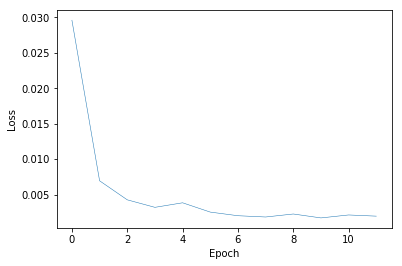

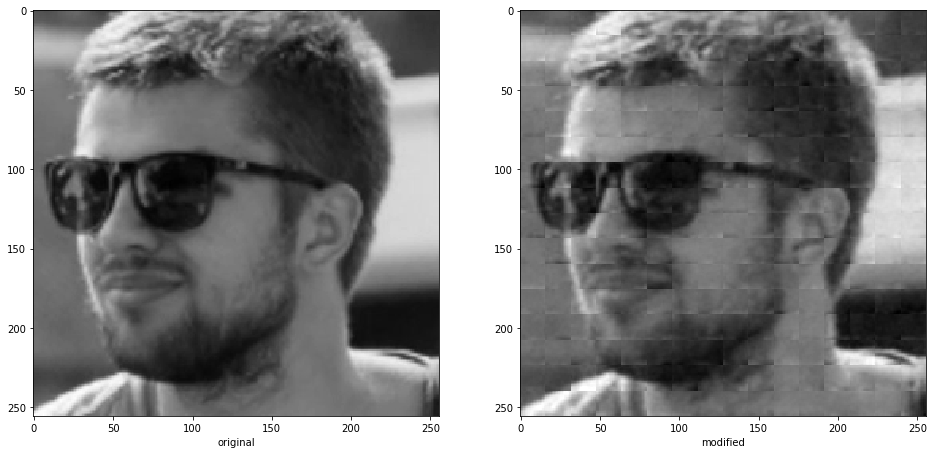

Error: 1999.9412841796875
running for z=0.44999999999999996
Train on 204 samples, validate on 52 samples
Train begin {}
Epoch 1/200
Epoch: 0 Error: 4242.3193359375
Epoch 2/200
Epoch: 1 Error: 3531.324462890625
Epoch 3/200
Epoch: 2 Error: 3099.416748046875
Epoch 4/200
Epoch: 3 Error: 2910.584228515625
Epoch 5/200
Epoch: 4 Error: 2693.07421875
Epoch 6/200
Epoch: 5 Error: 2598.84521484375
Epoch 7/200
Epoch: 6 Error: 2427.072998046875
Epoch 8/200
Epoch: 7 Error: 2385.131591796875
Epoch 9/200
Epoch: 8 Error: 2293.555419921875
Epoch 10/200
Epoch: 9 Error: 2316.734375
Epoch 11/200
Epoch: 10 Error: 2184.780517578125
Epoch 12/200
Epoch: 11 Error: 2340.202880859375
Epoch 13/200
Epoch: 12 Error: 2130.767578125
Epoch 14/200
Epoch: 13 Error: 2043.29541015625
Epoch 15/200
Epoch: 14 Error: 2003.7021484375
Epoch 16/200
Epoch: 15 Error: 2084.134033203125
Epoch 17/200
Epoch: 16 Error: 2046.5865478515625
Epoch 18/200
Epoch: 17 Error: 1948.2568359375
Train End {}


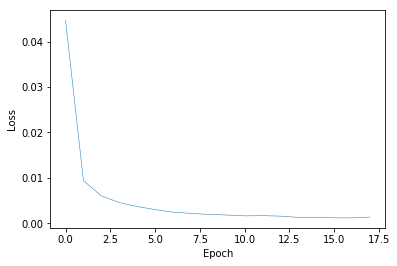

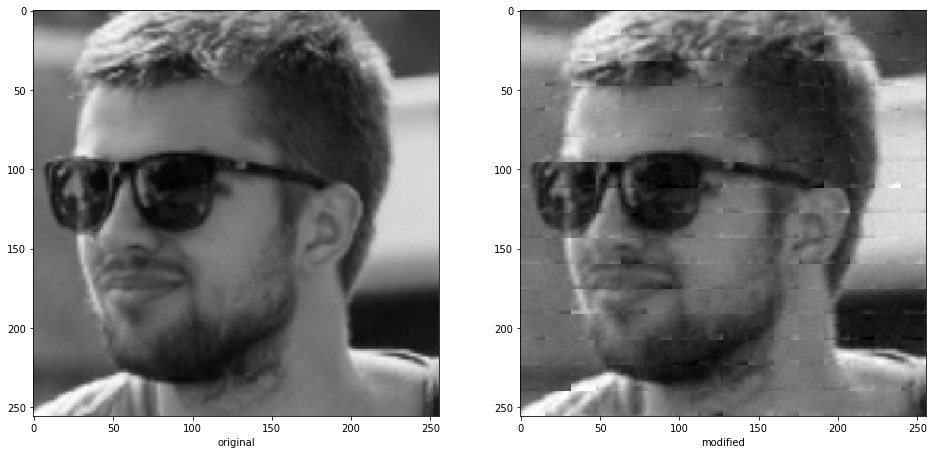

Error: 1948.2568359375
running for z=0.35
Train on 204 samples, validate on 52 samples
Train begin {}
Epoch 1/200
Epoch: 0 Error: 4331.3515625
Epoch 2/200
Epoch: 1 Error: 3684.39013671875
Epoch 3/200
Epoch: 2 Error: 3318.935791015625
Epoch 4/200
Epoch: 3 Error: 3023.732177734375
Epoch 5/200
Epoch: 4 Error: 2806.783447265625
Epoch 6/200
Epoch: 5 Error: 2653.826416015625
Epoch 7/200
Epoch: 6 Error: 2545.1201171875
Epoch 8/200
Epoch: 7 Error: 2460.02978515625
Epoch 9/200
Epoch: 8 Error: 2353.403564453125
Epoch 10/200
Epoch: 9 Error: 2293.075927734375
Epoch 11/200
Epoch: 10 Error: 2253.947509765625
Epoch 12/200
Epoch: 11 Error: 2189.568603515625
Epoch 13/200
Epoch: 12 Error: 2096.129638671875
Epoch 14/200
Epoch: 13 Error: 2036.0284423828125
Epoch 15/200
Epoch: 14 Error: 2047.98681640625
Epoch 16/200
Epoch: 15 Error: 2029.4716796875
Epoch 17/200
Epoch: 16 Error: 1990.0858154296875
Train End {}


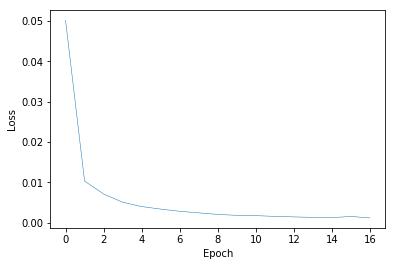

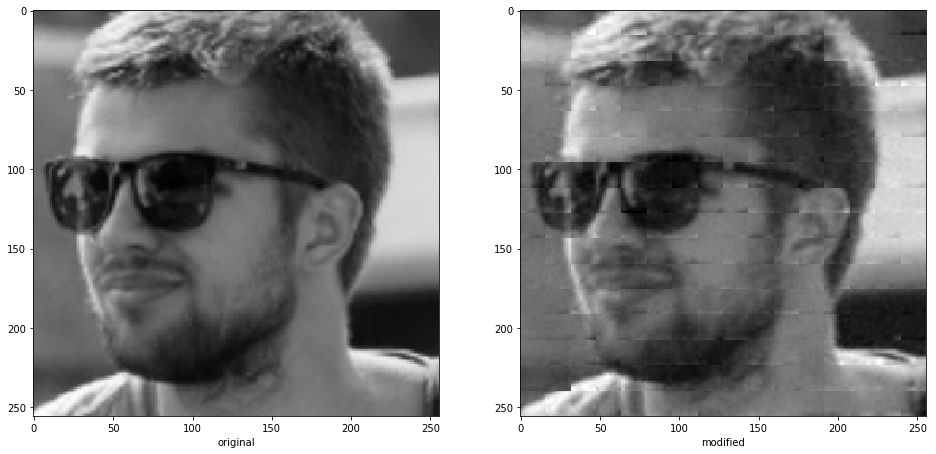

Error: 1990.0858154296875
running for z=0.25
Train on 204 samples, validate on 52 samples
Train begin {}
Epoch 1/200
Epoch: 0 Error: 6107.4775390625
Epoch 2/200
Epoch: 1 Error: 4446.62060546875
Epoch 3/200
Epoch: 2 Error: 3894.55908203125
Epoch 4/200
Epoch: 3 Error: 3692.7666015625
Epoch 5/200
Epoch: 4 Error: 3498.58544921875
Epoch 6/200
Epoch: 5 Error: 3298.031005859375
Epoch 7/200
Epoch: 6 Error: 3084.586181640625
Epoch 8/200
Epoch: 7 Error: 2959.278564453125
Epoch 9/200
Epoch: 8 Error: 2876.760498046875
Epoch 10/200
Epoch: 9 Error: 2809.26318359375
Epoch 11/200
Epoch: 10 Error: 2672.61279296875
Epoch 12/200
Epoch: 11 Error: 2622.504150390625
Epoch 13/200
Epoch: 12 Error: 2597.603271484375
Epoch 14/200
Epoch: 13 Error: 2483.56396484375
Epoch 15/200
Epoch: 14 Error: 2443.884521484375
Epoch 16/200
Epoch: 15 Error: 2391.926025390625
Epoch 17/200
Epoch: 16 Error: 2348.58544921875
Epoch 18/200
Epoch: 17 Error: 2345.92822265625
Epoch 19/200
Epoch: 18 Error: 2318.856689453125
Epoch 20/200
E

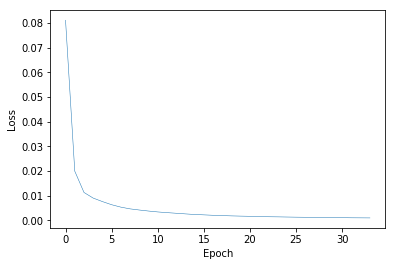

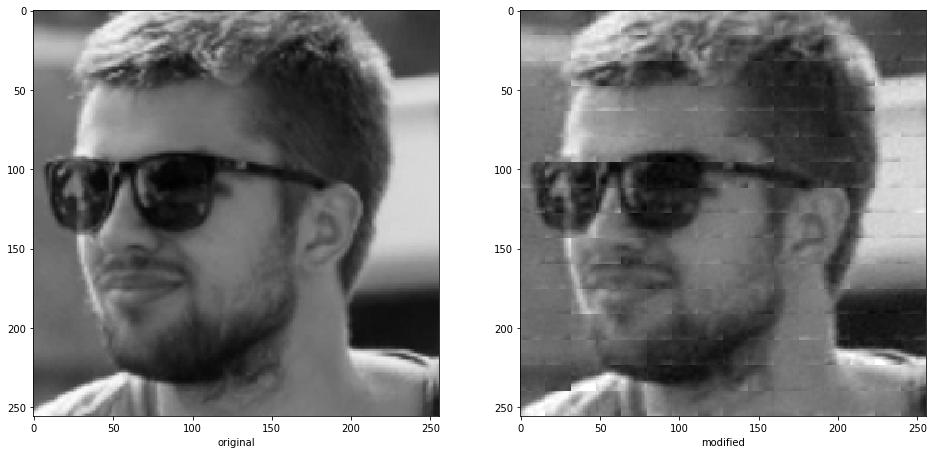

Error: 1994.93212890625
running for z=0.15
Train on 204 samples, validate on 52 samples
Train begin {}
Epoch 1/200
Epoch: 0 Error: 6931.365234375
Epoch 2/200
Epoch: 1 Error: 5796.28125
Epoch 3/200
Epoch: 2 Error: 4831.541015625
Epoch 4/200
Epoch: 3 Error: 4172.697265625
Epoch 5/200
Epoch: 4 Error: 3893.719970703125
Epoch 6/200
Epoch: 5 Error: 3772.533203125
Epoch 7/200
Epoch: 6 Error: 3706.980224609375
Epoch 8/200
Epoch: 7 Error: 3577.65283203125
Epoch 9/200
Epoch: 8 Error: 3477.880615234375
Epoch 10/200
Epoch: 9 Error: 3371.864501953125
Epoch 11/200
Epoch: 10 Error: 3279.60791015625
Epoch 12/200
Epoch: 11 Error: 3161.415771484375
Epoch 13/200
Epoch: 12 Error: 3098.3740234375
Epoch 14/200
Epoch: 13 Error: 2983.93505859375
Epoch 15/200
Epoch: 14 Error: 2916.1845703125
Epoch 16/200
Epoch: 15 Error: 2860.530029296875
Epoch 17/200
Epoch: 16 Error: 2801.611328125
Epoch 18/200
Epoch: 17 Error: 2765.3349609375
Epoch 19/200
Epoch: 18 Error: 2722.57568359375
Epoch 20/200
Epoch: 19 Error: 2674.9

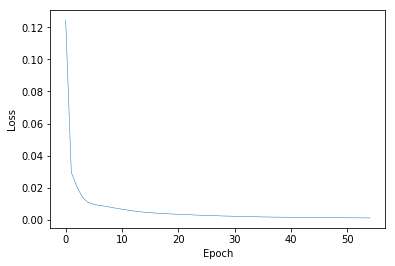

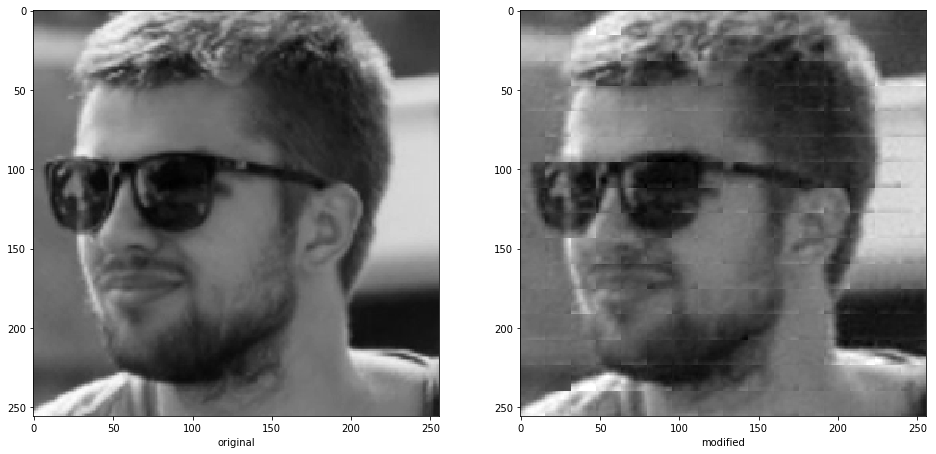

Error: 1989.131591796875
running for z=0.05
Train on 204 samples, validate on 52 samples
Train begin {}
Epoch 1/200
Epoch: 0 Error: 13862.7119140625
Epoch 2/200
Epoch: 1 Error: 12049.9033203125
Epoch 3/200
Epoch: 2 Error: 9900.2392578125
Epoch 4/200
Epoch: 3 Error: 7991.2021484375
Epoch 5/200
Epoch: 4 Error: 6950.9306640625
Epoch 6/200
Epoch: 5 Error: 6493.40478515625
Epoch 7/200
Epoch: 6 Error: 6233.36572265625
Epoch 8/200
Epoch: 7 Error: 6106.57421875
Epoch 9/200
Epoch: 8 Error: 5957.57470703125
Epoch 10/200
Epoch: 9 Error: 5797.044921875
Epoch 11/200
Epoch: 10 Error: 5605.84326171875
Epoch 12/200
Epoch: 11 Error: 5432.35693359375
Epoch 13/200
Epoch: 12 Error: 5214.02001953125
Epoch 14/200
Epoch: 13 Error: 5003.26953125
Epoch 15/200
Epoch: 14 Error: 4793.669921875
Epoch 16/200
Epoch: 15 Error: 4622.208984375
Epoch 17/200
Epoch: 16 Error: 4451.5029296875
Epoch 18/200
Epoch: 17 Error: 4313.7001953125
Epoch 19/200
Epoch: 18 Error: 4192.052734375
Epoch 20/200
Epoch: 19 Error: 4103.207519

Epoch: 171 Error: 2638.423095703125
Epoch 173/200
Epoch: 172 Error: 2633.759033203125
Epoch 174/200
Epoch: 173 Error: 2632.203125
Epoch 175/200
Epoch: 174 Error: 2630.440673828125
Epoch 176/200
Epoch: 175 Error: 2618.243896484375
Epoch 177/200
Epoch: 176 Error: 2615.87158203125
Epoch 178/200
Epoch: 177 Error: 2618.78271484375
Epoch 179/200
Epoch: 178 Error: 2611.357421875
Epoch 180/200
Epoch: 179 Error: 2610.286865234375
Epoch 181/200
Epoch: 180 Error: 2607.26318359375
Epoch 182/200
Epoch: 181 Error: 2606.389404296875
Epoch 183/200
Epoch: 182 Error: 2600.847900390625
Epoch 184/200
Epoch: 183 Error: 2594.5703125
Epoch 185/200
Epoch: 184 Error: 2595.514892578125
Epoch 186/200
Epoch: 185 Error: 2589.3203125
Epoch 187/200
Epoch: 186 Error: 2577.45361328125
Epoch 188/200
Epoch: 187 Error: 2577.610595703125
Epoch 189/200
Epoch: 188 Error: 2571.191650390625
Epoch 190/200
Epoch: 189 Error: 2578.3330078125
Epoch 191/200
Epoch: 190 Error: 2577.76611328125
Epoch 192/200
Epoch: 191 Error: 2574.000

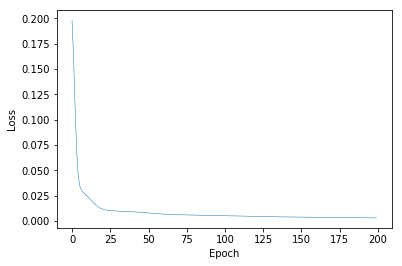

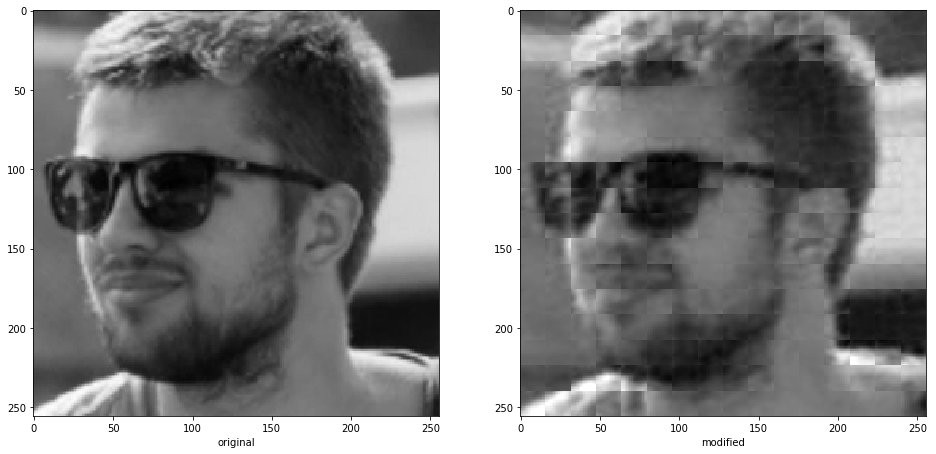

Error: 2543.919677734375


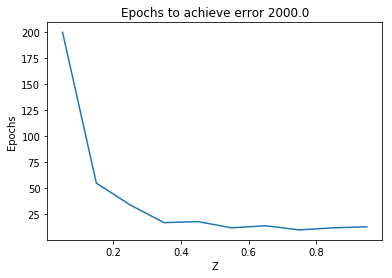

In [494]:
N_z = 10
zs = np.linspace(0.05, 0.95, N_z)
MAX_EPOCHS = 200
TH_ERR = 2000.0

epochs = np.array([])
for z in zs[::-1]:
    print('running for z={}'.format(z))
    model = Autoencoder(input_layers=N, z=z, max_epochs=MAX_EPOCHS, min_error=TH_ERR)
    best_results = try_run(model)
    epochs = np.append(epochs, best_results['epoch'])
    print('Error:', best_results['min_err'])
    
plt.plot(zs[::-1], epochs)
plt.title('Epochs to achieve error {}'.format(TH_ERR))
plt.xlabel('Z')
plt.ylabel('Epochs')
plt.show()

Как видно из приведенного графика, при $Z \leqslant 0.5$ количества эпох в размере $3000$ не хватает, чтобы достичь ошибки в $10.0$, и лишь для следующих коэффициентов это удается сделать. При этом сходится алгоритм значительно быстро - кривая очень наклонена

Построим график заивимости количества эпох от пороговой ошибки. Фиксированные параметры:
- `z`: 0.6
- `epoch`: 3000
- `dynamic_lr`: True

running for thr_err=3000.0
Train on 204 samples, validate on 52 samples
Train begin {}
Epoch 1/200
Epoch: 0 Error: 14330.0849609375
Epoch 2/200
Epoch: 1 Error: 13080.451171875
Epoch 3/200
Epoch: 2 Error: 11334.126953125
Epoch 4/200
Epoch: 3 Error: 9428.892578125
Epoch 5/200
Epoch: 4 Error: 7940.97216796875
Epoch 6/200
Epoch: 5 Error: 7015.6201171875
Epoch 7/200
Epoch: 6 Error: 6494.21728515625
Epoch 8/200
Epoch: 7 Error: 6175.41552734375
Epoch 9/200
Epoch: 8 Error: 5946.46875
Epoch 10/200
Epoch: 9 Error: 5717.10498046875
Epoch 11/200
Epoch: 10 Error: 5508.8681640625
Epoch 12/200
Epoch: 11 Error: 5285.34619140625
Epoch 13/200
Epoch: 12 Error: 5043.625
Epoch 14/200
Epoch: 13 Error: 4828.57470703125
Epoch 15/200
Epoch: 14 Error: 4628.66845703125
Epoch 16/200
Epoch: 15 Error: 4463.36376953125
Epoch 17/200
Epoch: 16 Error: 4332.79931640625
Epoch 18/200
Epoch: 17 Error: 4221.3955078125
Epoch 19/200
Epoch: 18 Error: 4132.6494140625
Epoch 20/200
Epoch: 19 Error: 4068.1494140625
Epoch 21/200
Ep

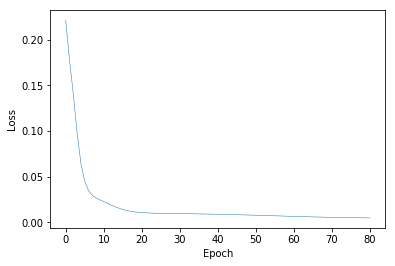

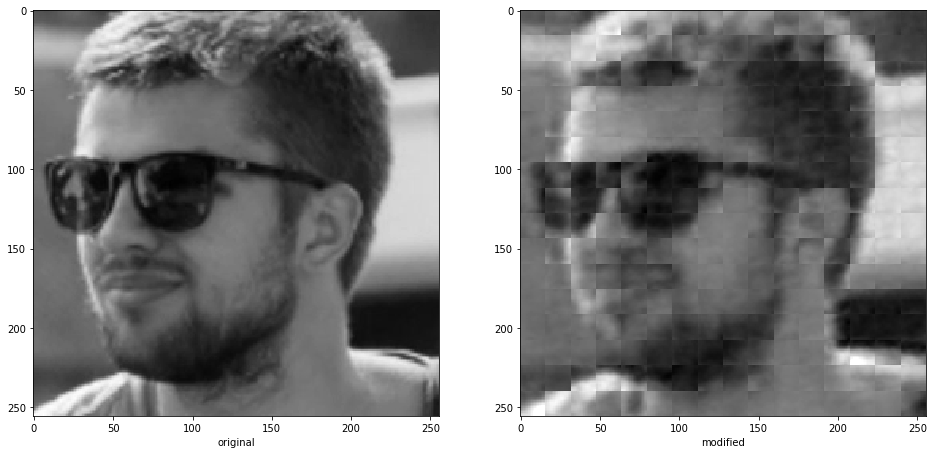

running for thr_err=2888.8888888888887
Train on 204 samples, validate on 52 samples
Train begin {}
Epoch 1/200
Epoch: 0 Error: 13731.1318359375
Epoch 2/200
Epoch: 1 Error: 12334.2705078125
Epoch 3/200
Epoch: 2 Error: 10615.6962890625
Epoch 4/200
Epoch: 3 Error: 8903.958984375
Epoch 5/200
Epoch: 4 Error: 7496.37255859375
Epoch 6/200
Epoch: 5 Error: 6658.95361328125
Epoch 7/200
Epoch: 6 Error: 6235.35986328125
Epoch 8/200
Epoch: 7 Error: 6015.52587890625
Epoch 9/200
Epoch: 8 Error: 5870.6103515625
Epoch 10/200
Epoch: 9 Error: 5733.58642578125
Epoch 11/200
Epoch: 10 Error: 5592.22265625
Epoch 12/200
Epoch: 11 Error: 5449.17529296875
Epoch 13/200
Epoch: 12 Error: 5298.67626953125
Epoch 14/200
Epoch: 13 Error: 5140.73828125
Epoch 15/200
Epoch: 14 Error: 4988.24755859375
Epoch 16/200
Epoch: 15 Error: 4821.97119140625
Epoch 17/200
Epoch: 16 Error: 4674.9921875
Epoch 18/200
Epoch: 17 Error: 4545.63330078125
Epoch 19/200
Epoch: 18 Error: 4385.302734375
Epoch 20/200
Epoch: 19 Error: 4269.8457031

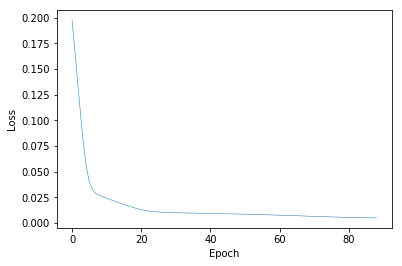

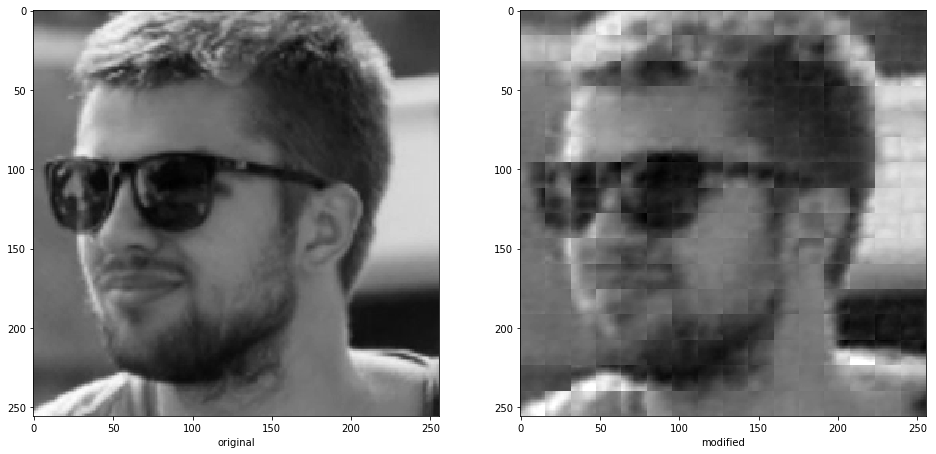

running for thr_err=2777.777777777778
Train on 204 samples, validate on 52 samples
Train begin {}
Epoch 1/200
Epoch: 0 Error: 13058.5693359375
Epoch 2/200
Epoch: 1 Error: 10860.25390625
Epoch 3/200
Epoch: 2 Error: 8784.98828125
Epoch 4/200
Epoch: 3 Error: 7453.96240234375
Epoch 5/200
Epoch: 4 Error: 6815.271484375
Epoch 6/200
Epoch: 5 Error: 6531.38818359375
Epoch 7/200
Epoch: 6 Error: 6366.65771484375
Epoch 8/200
Epoch: 7 Error: 6263.53271484375
Epoch 9/200
Epoch: 8 Error: 6198.24609375
Epoch 10/200
Epoch: 9 Error: 6131.51806640625
Epoch 11/200
Epoch: 10 Error: 6061.48876953125
Epoch 12/200
Epoch: 11 Error: 5963.99658203125
Epoch 13/200
Epoch: 12 Error: 5864.10595703125
Epoch 14/200
Epoch: 13 Error: 5773.25341796875
Epoch 15/200
Epoch: 14 Error: 5649.93896484375
Epoch 16/200
Epoch: 15 Error: 5539.8447265625
Epoch 17/200
Epoch: 16 Error: 5408.39892578125
Epoch 18/200
Epoch: 17 Error: 5267.298828125
Epoch 19/200
Epoch: 18 Error: 5133.234375
Epoch 20/200
Epoch: 19 Error: 4980.2431640625


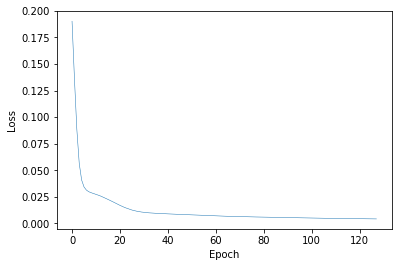

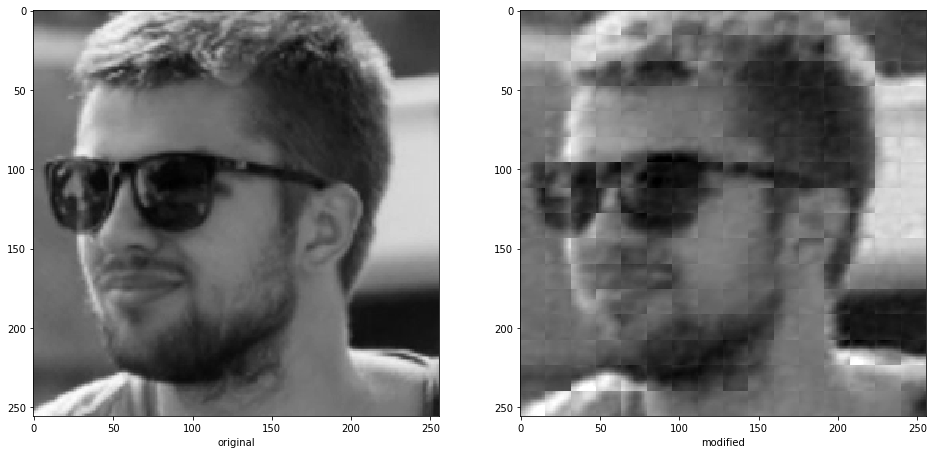

running for thr_err=2666.666666666667
Train on 204 samples, validate on 52 samples
Train begin {}
Epoch 1/200
Epoch: 0 Error: 13715.1435546875
Epoch 2/200
Epoch: 1 Error: 12080.9169921875
Epoch 3/200
Epoch: 2 Error: 10091.6513671875
Epoch 4/200
Epoch: 3 Error: 8524.0986328125
Epoch 5/200
Epoch: 4 Error: 7500.10546875
Epoch 6/200
Epoch: 5 Error: 6875.22021484375
Epoch 7/200
Epoch: 6 Error: 6525.7470703125
Epoch 8/200
Epoch: 7 Error: 6315.68310546875
Epoch 9/200
Epoch: 8 Error: 6183.669921875
Epoch 10/200
Epoch: 9 Error: 6085.24853515625
Epoch 11/200
Epoch: 10 Error: 5950.37353515625
Epoch 12/200
Epoch: 11 Error: 5822.89599609375
Epoch 13/200
Epoch: 12 Error: 5690.34326171875
Epoch 14/200
Epoch: 13 Error: 5550.5927734375
Epoch 15/200
Epoch: 14 Error: 5383.69140625
Epoch 16/200
Epoch: 15 Error: 5209.32958984375
Epoch 17/200
Epoch: 16 Error: 5080.51416015625
Epoch 18/200
Epoch: 17 Error: 4913.37353515625
Epoch 19/200
Epoch: 18 Error: 4742.1455078125
Epoch 20/200
Epoch: 19 Error: 4572.01074

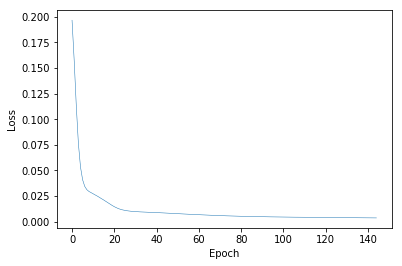

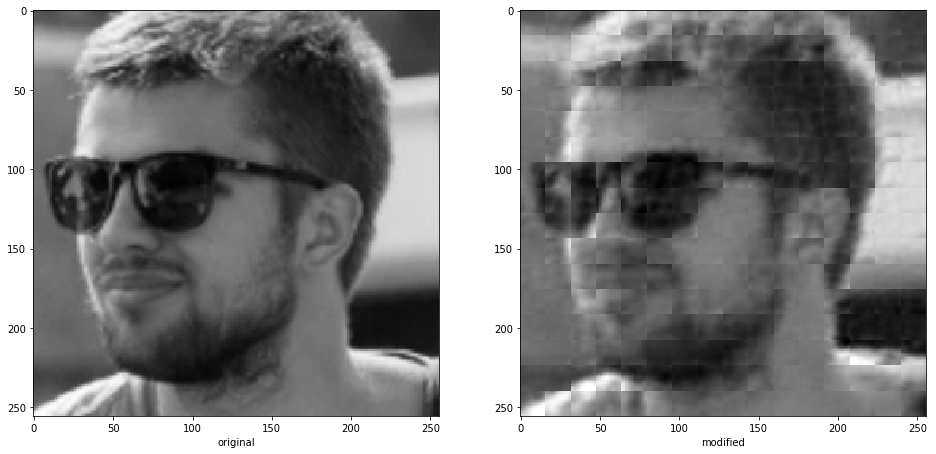

running for thr_err=2555.5555555555557
Train on 204 samples, validate on 52 samples
Train begin {}
Epoch 1/200
Epoch: 0 Error: 13156.640625
Epoch 2/200
Epoch: 1 Error: 11026.55078125
Epoch 3/200
Epoch: 2 Error: 8954.955078125
Epoch 4/200
Epoch: 3 Error: 7494.47900390625
Epoch 5/200
Epoch: 4 Error: 6766.62646484375
Epoch 6/200
Epoch: 5 Error: 6487.03173828125
Epoch 7/200
Epoch: 6 Error: 6341.48388671875
Epoch 8/200
Epoch: 7 Error: 6252.85595703125
Epoch 9/200
Epoch: 8 Error: 6188.3740234375
Epoch 10/200
Epoch: 9 Error: 6068.09423828125
Epoch 11/200
Epoch: 10 Error: 5940.84326171875
Epoch 12/200
Epoch: 11 Error: 5806.16064453125
Epoch 13/200
Epoch: 12 Error: 5638.2998046875
Epoch 14/200
Epoch: 13 Error: 5460.82666015625
Epoch 15/200
Epoch: 14 Error: 5318.29052734375
Epoch 16/200
Epoch: 15 Error: 5145.9287109375
Epoch 17/200
Epoch: 16 Error: 5024.888671875
Epoch 18/200
Epoch: 17 Error: 4899.3876953125
Epoch 19/200
Epoch: 18 Error: 4800.94189453125
Epoch 20/200
Epoch: 19 Error: 4687.221191

Epoch: 171 Error: 2593.967529296875
Epoch 173/200
Epoch: 172 Error: 2581.200927734375
Epoch 174/200
Epoch: 173 Error: 2580.99560546875
Epoch 175/200
Epoch: 174 Error: 2577.395263671875
Epoch 176/200
Epoch: 175 Error: 2568.555419921875
Epoch 177/200
Epoch: 176 Error: 2562.474853515625
Epoch 178/200
Epoch: 177 Error: 2564.16357421875
Epoch 179/200
Epoch: 178 Error: 2553.826171875
Train End {}


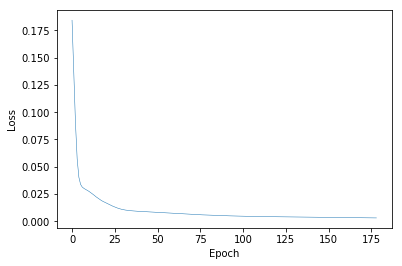

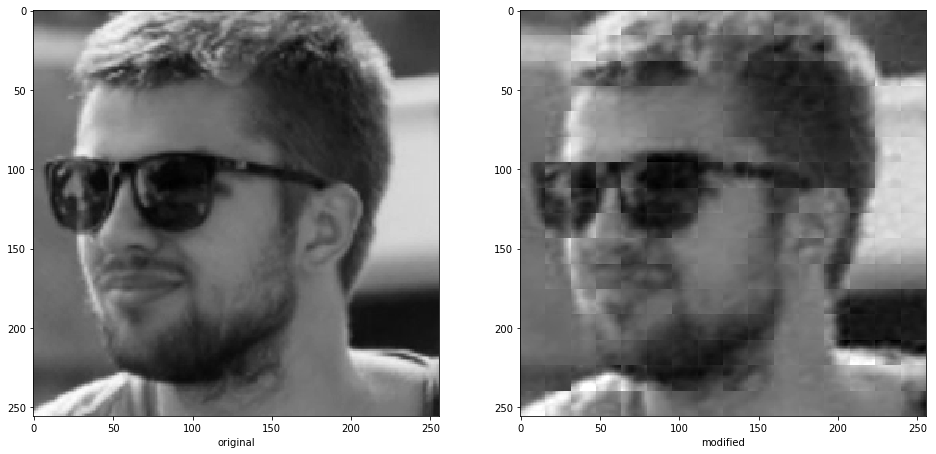

running for thr_err=2444.4444444444443
Train on 204 samples, validate on 52 samples
Train begin {}
Epoch 1/200
Epoch: 0 Error: 13949.0849609375
Epoch 2/200
Epoch: 1 Error: 12615.5615234375
Epoch 3/200
Epoch: 2 Error: 10932.5107421875
Epoch 4/200
Epoch: 3 Error: 9230.7939453125
Epoch 5/200
Epoch: 4 Error: 7786.169921875
Epoch 6/200
Epoch: 5 Error: 6841.26806640625
Epoch 7/200
Epoch: 6 Error: 6320.68115234375
Epoch 8/200
Epoch: 7 Error: 6031.86669921875
Epoch 9/200
Epoch: 8 Error: 5817.61474609375
Epoch 10/200
Epoch: 9 Error: 5594.37060546875
Epoch 11/200
Epoch: 10 Error: 5374.5732421875
Epoch 12/200
Epoch: 11 Error: 5157.6572265625
Epoch 13/200
Epoch: 12 Error: 4945.6875
Epoch 14/200
Epoch: 13 Error: 4736.04541015625
Epoch 15/200
Epoch: 14 Error: 4549.1494140625
Epoch 16/200
Epoch: 15 Error: 4398.380859375
Epoch 17/200
Epoch: 16 Error: 4266.3017578125
Epoch 18/200
Epoch: 17 Error: 4163.88232421875
Epoch 19/200
Epoch: 18 Error: 4084.478759765625
Epoch 20/200
Epoch: 19 Error: 4012.0126953

Epoch: 172 Error: 2556.20361328125
Epoch 174/200
Epoch: 173 Error: 2557.84521484375
Epoch 175/200
Epoch: 174 Error: 2549.831787109375
Epoch 176/200
Epoch: 175 Error: 2550.28662109375
Epoch 177/200
Epoch: 176 Error: 2540.4150390625
Epoch 178/200
Epoch: 177 Error: 2544.696044921875
Epoch 179/200
Epoch: 178 Error: 2535.54833984375
Epoch 180/200
Epoch: 179 Error: 2534.99072265625
Epoch 181/200
Epoch: 180 Error: 2527.66748046875
Epoch 182/200
Epoch: 181 Error: 2529.433349609375
Epoch 183/200
Epoch: 182 Error: 2522.475830078125
Epoch 184/200
Epoch: 183 Error: 2525.601806640625
Epoch 185/200
Epoch: 184 Error: 2516.426513671875
Epoch 186/200
Epoch: 185 Error: 2513.9326171875
Epoch 187/200
Epoch: 186 Error: 2513.735107421875
Epoch 188/200
Epoch: 187 Error: 2504.03515625
Epoch 189/200
Epoch: 188 Error: 2507.547607421875
Epoch 190/200
Epoch: 189 Error: 2502.924560546875
Epoch 191/200
Epoch: 190 Error: 2498.88916015625
Epoch 192/200
Epoch: 191 Error: 2493.040771484375
Epoch 193/200
Epoch: 192 Erro

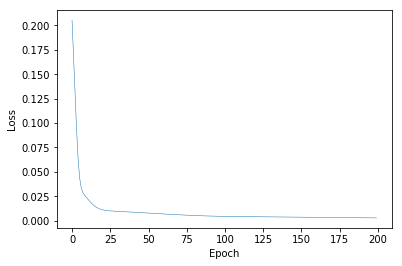

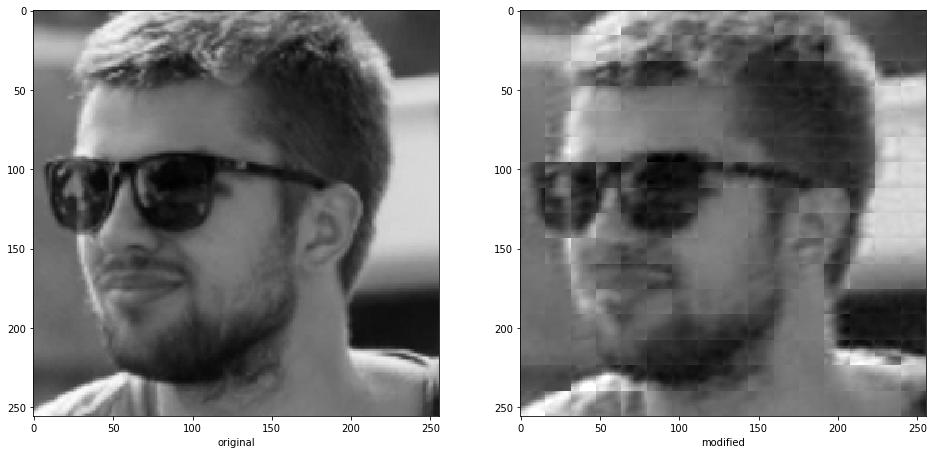

running for thr_err=2333.3333333333335
Train on 204 samples, validate on 52 samples
Train begin {}
Epoch 1/200
Epoch: 0 Error: 13521.1435546875
Epoch 2/200
Epoch: 1 Error: 11863.8828125
Epoch 3/200
Epoch: 2 Error: 10000.28125
Epoch 4/200
Epoch: 3 Error: 8537.451171875
Epoch 5/200
Epoch: 4 Error: 7546.10791015625
Epoch 6/200
Epoch: 5 Error: 6935.51025390625
Epoch 7/200
Epoch: 6 Error: 6552.82666015625
Epoch 8/200
Epoch: 7 Error: 6299.9072265625
Epoch 9/200
Epoch: 8 Error: 6116.79541015625
Epoch 10/200
Epoch: 9 Error: 5972.9853515625
Epoch 11/200
Epoch: 10 Error: 5831.13623046875
Epoch 12/200
Epoch: 11 Error: 5673.83837890625
Epoch 13/200
Epoch: 12 Error: 5489.35595703125
Epoch 14/200
Epoch: 13 Error: 5318.6552734375
Epoch 15/200
Epoch: 14 Error: 5111.0869140625
Epoch 16/200
Epoch: 15 Error: 4903.74853515625
Epoch 17/200
Epoch: 16 Error: 4701.37060546875
Epoch 18/200
Epoch: 17 Error: 4527.44091796875
Epoch 19/200
Epoch: 18 Error: 4370.05517578125
Epoch 20/200
Epoch: 19 Error: 4258.036132

Epoch: 172 Error: 2516.662353515625
Epoch 174/200
Epoch: 173 Error: 2513.859375
Epoch 175/200
Epoch: 174 Error: 2511.589111328125
Epoch 176/200
Epoch: 175 Error: 2505.369140625
Epoch 177/200
Epoch: 176 Error: 2500.517578125
Epoch 178/200
Epoch: 177 Error: 2498.2353515625
Epoch 179/200
Epoch: 178 Error: 2493.828857421875
Epoch 180/200
Epoch: 179 Error: 2490.804931640625
Epoch 181/200
Epoch: 180 Error: 2485.85791015625
Epoch 182/200
Epoch: 181 Error: 2477.90576171875
Epoch 183/200
Epoch: 182 Error: 2476.749755859375
Epoch 184/200
Epoch: 183 Error: 2472.47265625
Epoch 185/200
Epoch: 184 Error: 2463.91943359375
Epoch 186/200
Epoch: 185 Error: 2467.459716796875
Epoch 187/200
Epoch: 186 Error: 2462.581298828125
Epoch 188/200
Epoch: 187 Error: 2458.63427734375
Epoch 189/200
Epoch: 188 Error: 2452.40185546875
Epoch 190/200
Epoch: 189 Error: 2452.610107421875
Epoch 191/200
Epoch: 190 Error: 2442.12744140625
Epoch 192/200
Epoch: 191 Error: 2440.25048828125
Epoch 193/200
Epoch: 192 Error: 2431.12

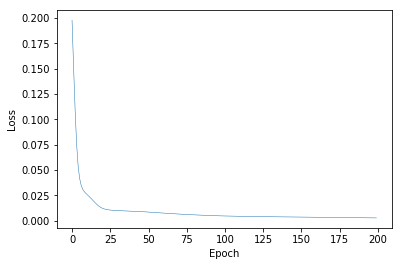

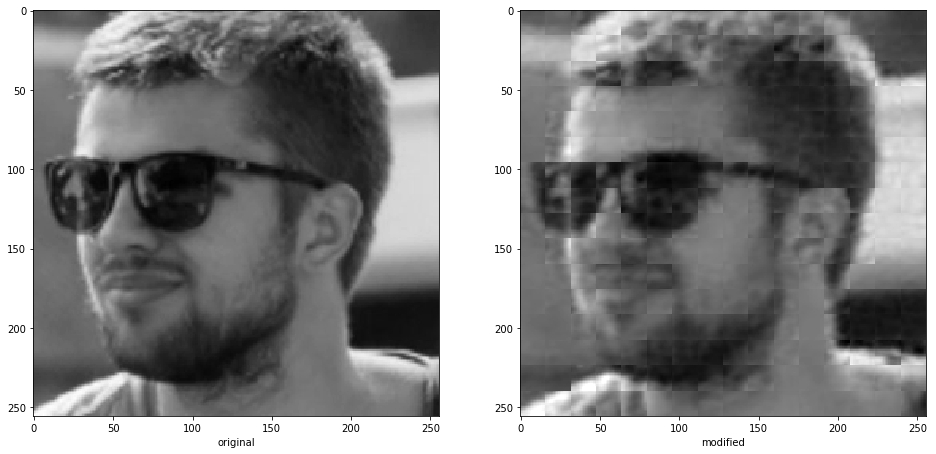

running for thr_err=2222.222222222222
Train on 204 samples, validate on 52 samples
Train begin {}
Epoch 1/200
Epoch: 0 Error: 13520.2509765625
Epoch 2/200
Epoch: 1 Error: 11796.1201171875
Epoch 3/200
Epoch: 2 Error: 9838.154296875
Epoch 4/200
Epoch: 3 Error: 8182.48095703125
Epoch 5/200
Epoch: 4 Error: 7135.7939453125
Epoch 6/200
Epoch: 5 Error: 6597.71484375
Epoch 7/200
Epoch: 6 Error: 6301.865234375
Epoch 8/200
Epoch: 7 Error: 6182.63818359375
Epoch 9/200
Epoch: 8 Error: 6035.029296875
Epoch 10/200
Epoch: 9 Error: 5917.23779296875
Epoch 11/200
Epoch: 10 Error: 5778.12548828125
Epoch 12/200
Epoch: 11 Error: 5645.65087890625
Epoch 13/200
Epoch: 12 Error: 5495.14453125
Epoch 14/200
Epoch: 13 Error: 5344.35546875
Epoch 15/200
Epoch: 14 Error: 5182.7080078125
Epoch 16/200
Epoch: 15 Error: 4983.4609375
Epoch 17/200
Epoch: 16 Error: 4809.056640625
Epoch 18/200
Epoch: 17 Error: 4624.18701171875
Epoch 19/200
Epoch: 18 Error: 4459.98876953125
Epoch 20/200
Epoch: 19 Error: 4319.4775390625
Epoch

Epoch: 171 Error: 2521.93896484375
Epoch 173/200
Epoch: 172 Error: 2513.958740234375
Epoch 174/200
Epoch: 173 Error: 2516.059326171875
Epoch 175/200
Epoch: 174 Error: 2512.493408203125
Epoch 176/200
Epoch: 175 Error: 2506.7451171875
Epoch 177/200
Epoch: 176 Error: 2506.21337890625
Epoch 178/200
Epoch: 177 Error: 2509.147216796875
Epoch 179/200
Epoch: 178 Error: 2498.422119140625
Epoch 180/200
Epoch: 179 Error: 2503.56689453125
Epoch 181/200
Epoch: 180 Error: 2499.723876953125
Epoch 182/200
Epoch: 181 Error: 2501.294189453125
Epoch 183/200
Epoch: 182 Error: 2491.46533203125
Epoch 184/200
Epoch: 183 Error: 2493.26904296875
Epoch 185/200
Epoch: 184 Error: 2496.666259765625
Epoch 186/200
Epoch: 185 Error: 2492.783203125
Epoch 187/200
Epoch: 186 Error: 2487.21044921875
Epoch 188/200
Epoch: 187 Error: 2483.429443359375
Epoch 189/200
Epoch: 188 Error: 2482.427734375
Epoch 190/200
Epoch: 189 Error: 2482.205810546875
Epoch 191/200
Epoch: 190 Error: 2478.490966796875
Epoch 192/200
Epoch: 191 Err

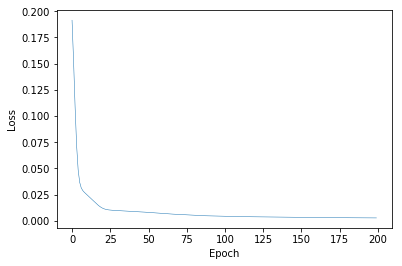

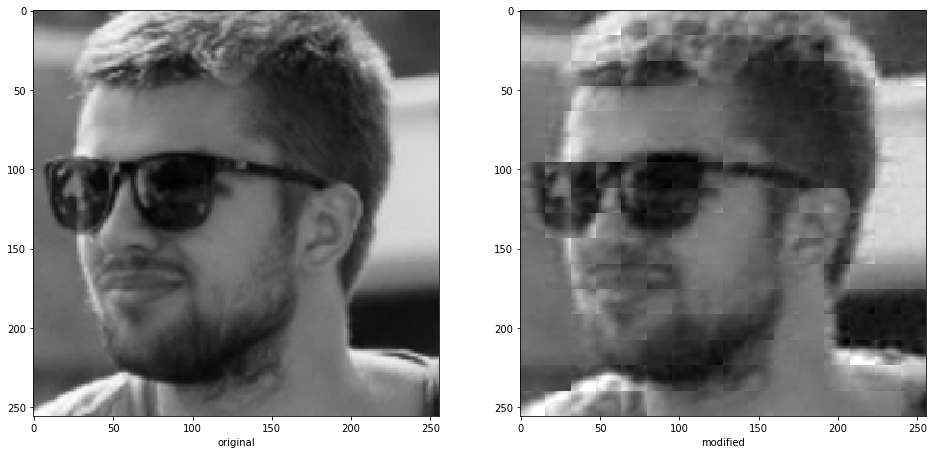

running for thr_err=2111.1111111111113
Train on 204 samples, validate on 52 samples
Train begin {}
Epoch 1/200
Epoch: 0 Error: 13795.5986328125
Epoch 2/200
Epoch: 1 Error: 12259.5869140625
Epoch 3/200
Epoch: 2 Error: 10468.4736328125
Epoch 4/200
Epoch: 3 Error: 8865.7412109375
Epoch 5/200
Epoch: 4 Error: 7633.82568359375
Epoch 6/200
Epoch: 5 Error: 6942.0908203125
Epoch 7/200
Epoch: 6 Error: 6624.84033203125
Epoch 8/200
Epoch: 7 Error: 6476.99267578125
Epoch 9/200
Epoch: 8 Error: 6377.66845703125
Epoch 10/200
Epoch: 9 Error: 6290.65771484375
Epoch 11/200
Epoch: 10 Error: 6208.9208984375
Epoch 12/200
Epoch: 11 Error: 6153.9013671875
Epoch 13/200
Epoch: 12 Error: 6082.93310546875
Epoch 14/200
Epoch: 13 Error: 5986.6005859375
Epoch 15/200
Epoch: 14 Error: 5879.95849609375
Epoch 16/200
Epoch: 15 Error: 5763.1220703125
Epoch 17/200
Epoch: 16 Error: 5636.87158203125
Epoch 18/200
Epoch: 17 Error: 5519.61572265625
Epoch 19/200
Epoch: 18 Error: 5378.734375
Epoch 20/200
Epoch: 19 Error: 5207.408

Epoch: 172 Error: 2695.66015625
Epoch 174/200
Epoch: 173 Error: 2691.916259765625
Epoch 175/200
Epoch: 174 Error: 2684.1669921875
Epoch 176/200
Epoch: 175 Error: 2679.129150390625
Epoch 177/200
Epoch: 176 Error: 2678.941650390625
Epoch 178/200
Epoch: 177 Error: 2677.7392578125
Epoch 179/200
Epoch: 178 Error: 2669.522216796875
Epoch 180/200
Epoch: 179 Error: 2667.608154296875
Epoch 181/200
Epoch: 180 Error: 2659.055419921875
Epoch 182/200
Epoch: 181 Error: 2662.6162109375
Epoch 183/200
Epoch: 182 Error: 2658.4453125
Epoch 184/200
Epoch: 183 Error: 2647.872314453125
Epoch 185/200
Epoch: 184 Error: 2646.273681640625
Epoch 186/200
Epoch: 185 Error: 2646.829833984375
Epoch 187/200
Epoch: 186 Error: 2640.512451171875
Epoch 188/200
Epoch: 187 Error: 2631.50146484375
Epoch 189/200
Epoch: 188 Error: 2635.393798828125
Epoch 190/200
Epoch: 189 Error: 2624.97314453125
Epoch 191/200
Epoch: 190 Error: 2620.355712890625
Epoch 192/200
Epoch: 191 Error: 2622.97412109375
Epoch 193/200
Epoch: 192 Error: 

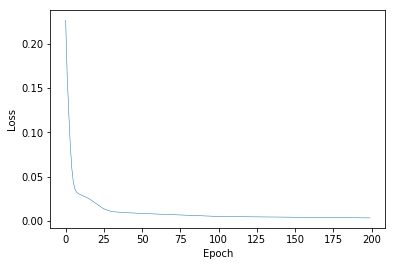

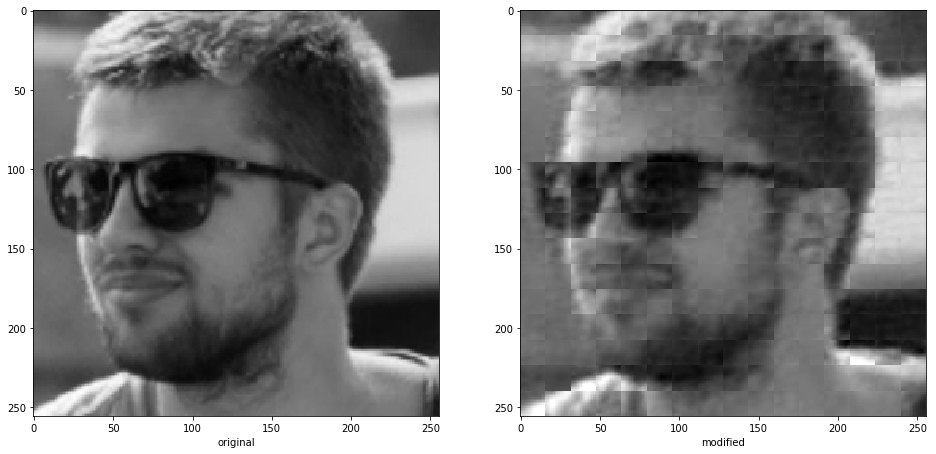

running for thr_err=2000.0
Train on 204 samples, validate on 52 samples
Train begin {}
Epoch 1/200
Epoch: 0 Error: 13502.0380859375
Epoch 2/200
Epoch: 1 Error: 11632.623046875
Epoch 3/200
Epoch: 2 Error: 9472.0859375
Epoch 4/200
Epoch: 3 Error: 7755.15625
Epoch 5/200
Epoch: 4 Error: 6889.447265625
Epoch 6/200
Epoch: 5 Error: 6539.17724609375
Epoch 7/200
Epoch: 6 Error: 6348.19677734375
Epoch 8/200
Epoch: 7 Error: 6201.7939453125
Epoch 9/200
Epoch: 8 Error: 6116.72802734375
Epoch 10/200
Epoch: 9 Error: 5969.39453125
Epoch 11/200
Epoch: 10 Error: 5837.48291015625
Epoch 12/200
Epoch: 11 Error: 5710.349609375
Epoch 13/200
Epoch: 12 Error: 5550.19775390625
Epoch 14/200
Epoch: 13 Error: 5366.244140625
Epoch 15/200
Epoch: 14 Error: 5194.28857421875
Epoch 16/200
Epoch: 15 Error: 4984.720703125
Epoch 17/200
Epoch: 16 Error: 4796.4208984375
Epoch 18/200
Epoch: 17 Error: 4636.19189453125
Epoch 19/200
Epoch: 18 Error: 4473.1630859375
Epoch 20/200
Epoch: 19 Error: 4343.7939453125
Epoch 21/200
Epoch

Epoch: 171 Error: 2535.182861328125
Epoch 173/200
Epoch: 172 Error: 2524.42236328125
Epoch 174/200
Epoch: 173 Error: 2516.164306640625
Epoch 175/200
Epoch: 174 Error: 2517.5498046875
Epoch 176/200
Epoch: 175 Error: 2514.78955078125
Epoch 177/200
Epoch: 176 Error: 2506.779052734375
Epoch 178/200
Epoch: 177 Error: 2507.0185546875
Epoch 179/200
Epoch: 178 Error: 2494.83056640625
Epoch 180/200
Epoch: 179 Error: 2503.123291015625
Epoch 181/200
Epoch: 180 Error: 2493.111328125
Epoch 182/200
Epoch: 181 Error: 2488.8173828125
Epoch 183/200
Epoch: 182 Error: 2486.50146484375
Epoch 184/200
Epoch: 183 Error: 2481.039794921875
Epoch 185/200
Epoch: 184 Error: 2481.092041015625
Epoch 186/200
Epoch: 185 Error: 2473.2939453125
Epoch 187/200
Epoch: 186 Error: 2461.983642578125
Epoch 188/200
Epoch: 187 Error: 2470.13916015625
Epoch 189/200
Epoch: 188 Error: 2464.856689453125
Epoch 190/200
Epoch: 189 Error: 2459.383544921875
Epoch 191/200
Epoch: 190 Error: 2461.93603515625
Epoch 192/200
Epoch: 191 Error:

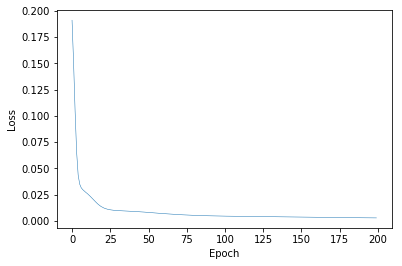

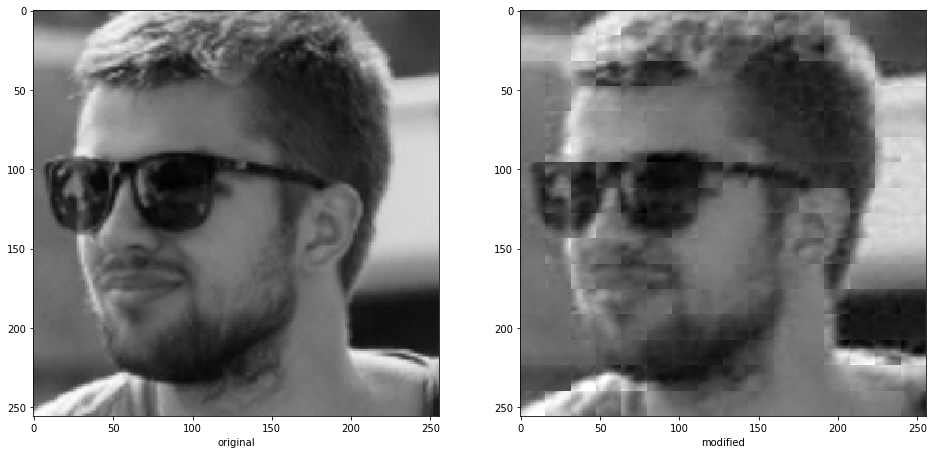

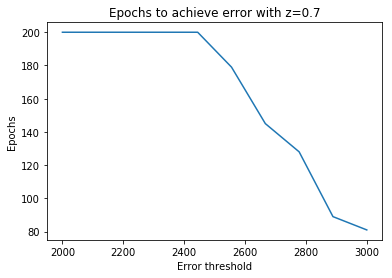

In [500]:
N_thr = 10
thrs = np.linspace(2000.0, 3000.0, N_thr)
MAX_EPOCHS = 200
Z = 0.7
epochs = np.array([])
for thr in thrs[::-1]:
    print('running for thr_err={}'.format(thr))
    model = Autoencoder(input_layers=N, z=z, max_epochs=MAX_EPOCHS, min_error=thr)
    best_results = try_run(model)
    epochs = np.append(epochs, best_results['epoch'])
    
plt.plot(thrs[::-1], epochs)
plt.title('Epochs to achieve error with z={}'.format(Z))
plt.xlabel('Error threshold')
plt.ylabel('Epochs')
plt.show()

Как и ожидалось, количество затраченных эпох до достижения пороговой ошибки гладко снижается

running for alpha=0.2
Train on 204 samples, validate on 52 samples
Train begin {}
Epoch 1/500
Epoch: 0 Error: 33464.25390625
Epoch 2/500
Epoch: 1 Error: 29249.619140625
Epoch 3/500
Epoch: 2 Error: 34536.30078125
Epoch 4/500
Epoch: 3 Error: 20572.29296875
Epoch 5/500
Epoch: 4 Error: 14211.6474609375
Epoch 6/500
Epoch: 5 Error: 12842.958984375
Epoch 7/500
Epoch: 6 Error: 11180.0703125
Epoch 8/500
Epoch: 7 Error: 9649.1953125
Epoch 9/500
Epoch: 8 Error: 8689.693359375
Epoch 10/500
Epoch: 9 Error: 7813.2353515625
Epoch 11/500
Epoch: 10 Error: 7236.103515625
Epoch 12/500
Epoch: 11 Error: 6831.95849609375
Epoch 13/500
Epoch: 12 Error: 6604.7890625
Epoch 14/500
Epoch: 13 Error: 6304.25927734375
Epoch 15/500
Epoch: 14 Error: 6053.62353515625
Epoch 16/500
Epoch: 15 Error: 5938.775390625
Epoch 17/500
Epoch: 16 Error: 5666.90283203125
Epoch 18/500
Epoch: 17 Error: 5585.732421875
Epoch 19/500
Epoch: 18 Error: 5335.77734375
Epoch 20/500
Epoch: 19 Error: 5202.55029296875
Epoch 21/500
Epoch: 20 Error

Epoch: 171 Error: 2696.984619140625
Epoch 173/500
Epoch: 172 Error: 2708.834228515625
Epoch 174/500
Epoch: 173 Error: 2739.3740234375
Epoch 175/500
Epoch: 174 Error: 2708.7900390625
Epoch 176/500
Epoch: 175 Error: 2714.136962890625
Epoch 177/500
Epoch: 176 Error: 2690.609619140625
Epoch 178/500
Epoch: 177 Error: 2717.016845703125
Epoch 179/500
Epoch: 178 Error: 2726.4853515625
Epoch 180/500
Epoch: 179 Error: 2703.2998046875
Epoch 181/500
Epoch: 180 Error: 2726.9169921875
Epoch 182/500
Epoch: 181 Error: 2695.185546875
Epoch 183/500
Epoch: 182 Error: 2681.141357421875
Epoch 184/500
Epoch: 183 Error: 2691.2529296875
Epoch 185/500
Epoch: 184 Error: 2696.934326171875
Epoch 186/500
Epoch: 185 Error: 2710.342529296875
Epoch 187/500
Epoch: 186 Error: 2686.4892578125
Epoch 188/500
Epoch: 187 Error: 2634.009033203125
Epoch 189/500
Epoch: 188 Error: 2669.09765625
Epoch 190/500
Epoch: 189 Error: 2714.498779296875
Epoch 191/500
Epoch: 190 Error: 2701.68505859375
Epoch 192/500
Epoch: 191 Error: 2646

Epoch: 339 Error: 2257.434814453125
Epoch 341/500
Epoch: 340 Error: 2268.2158203125
Epoch 342/500
Epoch: 341 Error: 2321.0185546875
Epoch 343/500
Epoch: 342 Error: 2322.4765625
Epoch 344/500
Epoch: 343 Error: 2286.646240234375
Epoch 345/500
Epoch: 344 Error: 2280.88720703125
Epoch 346/500
Epoch: 345 Error: 2287.177734375
Epoch 347/500
Epoch: 346 Error: 2281.0009765625
Epoch 348/500
Epoch: 347 Error: 2270.3759765625
Epoch 349/500
Epoch: 348 Error: 2268.767578125
Epoch 350/500
Epoch: 349 Error: 2262.064208984375
Epoch 351/500
Epoch: 350 Error: 2254.64892578125
Epoch 352/500
Epoch: 351 Error: 2266.047119140625
Epoch 353/500
Epoch: 352 Error: 2264.71630859375
Epoch 354/500
Epoch: 353 Error: 2274.565673828125
Epoch 355/500
Epoch: 354 Error: 2299.08740234375
Epoch 356/500
Epoch: 355 Error: 2268.68212890625
Epoch 357/500
Epoch: 356 Error: 2257.698486328125
Epoch 358/500
Epoch: 357 Error: 2267.416015625
Epoch 359/500
Epoch: 358 Error: 2279.984619140625
Epoch 360/500
Epoch: 359 Error: 2295.6035

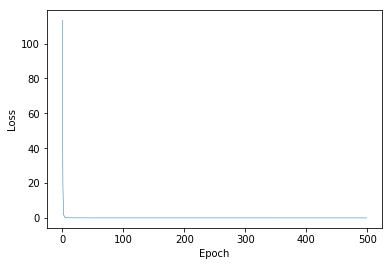

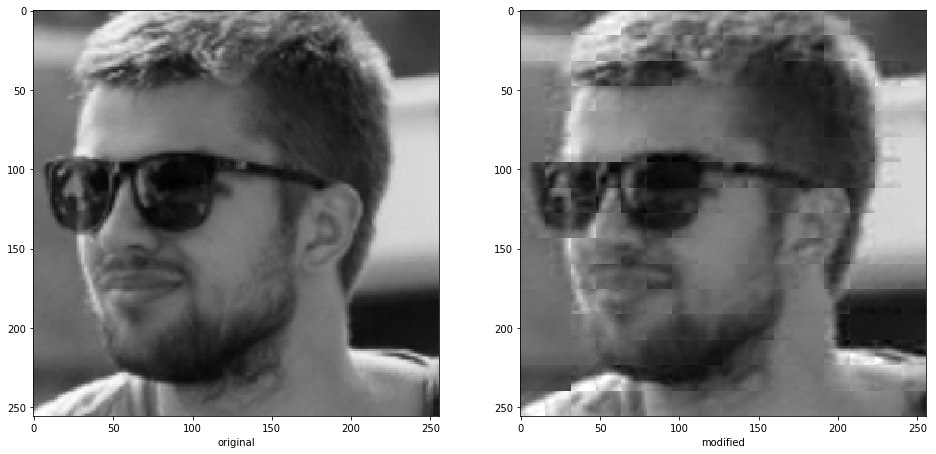

Error:  2130.11279296875
running for alpha=0.1778888888888889
Train on 204 samples, validate on 52 samples
Train begin {}
Epoch 1/500
Epoch: 0 Error: 37554.46875
Epoch 2/500
Epoch: 1 Error: 32140.95703125
Epoch 3/500
Epoch: 2 Error: 33880.3046875
Epoch 4/500
Epoch: 3 Error: 19138.55078125
Epoch 5/500
Epoch: 4 Error: 22237.3984375
Epoch 6/500
Epoch: 5 Error: 15636.1396484375
Epoch 7/500
Epoch: 6 Error: 12814.2509765625
Epoch 8/500
Epoch: 7 Error: 9367.095703125
Epoch 9/500
Epoch: 8 Error: 7727.90234375
Epoch 10/500
Epoch: 9 Error: 7000.84912109375
Epoch 11/500
Epoch: 10 Error: 6060.80078125
Epoch 12/500
Epoch: 11 Error: 5804.5595703125
Epoch 13/500
Epoch: 12 Error: 5645.013671875
Epoch 14/500
Epoch: 13 Error: 5614.8818359375
Epoch 15/500
Epoch: 14 Error: 5411.8896484375
Epoch 16/500
Epoch: 15 Error: 5532.22998046875
Epoch 17/500
Epoch: 16 Error: 5249.90869140625
Epoch 18/500
Epoch: 17 Error: 5209.2587890625
Epoch 19/500
Epoch: 18 Error: 5222.509765625
Epoch 20/500
Epoch: 19 Error: 4927.

Epoch: 172 Error: 2828.288818359375
Epoch 174/500
Epoch: 173 Error: 2706.621337890625
Epoch 175/500
Epoch: 174 Error: 2729.46533203125
Epoch 176/500
Epoch: 175 Error: 2664.05224609375
Epoch 177/500
Epoch: 176 Error: 3139.12646484375
Epoch 178/500
Epoch: 177 Error: 2836.375244140625
Epoch 179/500
Epoch: 178 Error: 2706.696044921875
Epoch 180/500
Epoch: 179 Error: 2677.81298828125
Epoch 181/500
Epoch: 180 Error: 2622.16845703125
Epoch 182/500
Epoch: 181 Error: 2635.3232421875
Epoch 183/500
Epoch: 182 Error: 2621.83837890625
Epoch 184/500
Epoch: 183 Error: 2597.369140625
Epoch 185/500
Epoch: 184 Error: 2589.11474609375
Epoch 186/500
Epoch: 185 Error: 2594.218017578125
Epoch 187/500
Epoch: 186 Error: 2599.056884765625
Epoch 188/500
Epoch: 187 Error: 2599.90283203125
Epoch 189/500
Epoch: 188 Error: 2593.584716796875
Epoch 190/500
Epoch: 189 Error: 2597.448974609375
Epoch 191/500
Epoch: 190 Error: 2573.2529296875
Epoch 192/500
Epoch: 191 Error: 2572.966552734375
Epoch 193/500
Epoch: 192 Erro

Epoch: 341 Error: 2368.880859375
Epoch 343/500
Epoch: 342 Error: 2353.190185546875
Epoch 344/500
Epoch: 343 Error: 2535.751220703125
Epoch 345/500
Epoch: 344 Error: 2519.883544921875
Epoch 346/500
Epoch: 345 Error: 2467.167236328125
Epoch 347/500
Epoch: 346 Error: 2423.4306640625
Epoch 348/500
Epoch: 347 Error: 2403.410400390625
Epoch 349/500
Epoch: 348 Error: 2346.70703125
Epoch 350/500
Epoch: 349 Error: 2363.688232421875
Epoch 351/500
Epoch: 350 Error: 2331.147705078125
Epoch 352/500
Epoch: 351 Error: 2336.00244140625
Epoch 353/500
Epoch: 352 Error: 2344.958984375
Epoch 354/500
Epoch: 353 Error: 2526.389404296875
Epoch 355/500
Epoch: 354 Error: 2378.262451171875
Epoch 356/500
Epoch: 355 Error: 2326.821044921875
Epoch 357/500
Epoch: 356 Error: 2446.0107421875
Epoch 358/500
Epoch: 357 Error: 2536.783203125
Epoch 359/500
Epoch: 358 Error: 2389.7197265625
Epoch 360/500
Epoch: 359 Error: 2356.14697265625
Epoch 361/500
Epoch: 360 Error: 2486.011474609375
Epoch 362/500
Epoch: 361 Error: 247

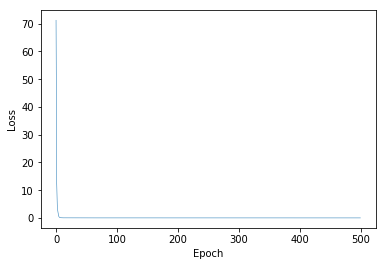

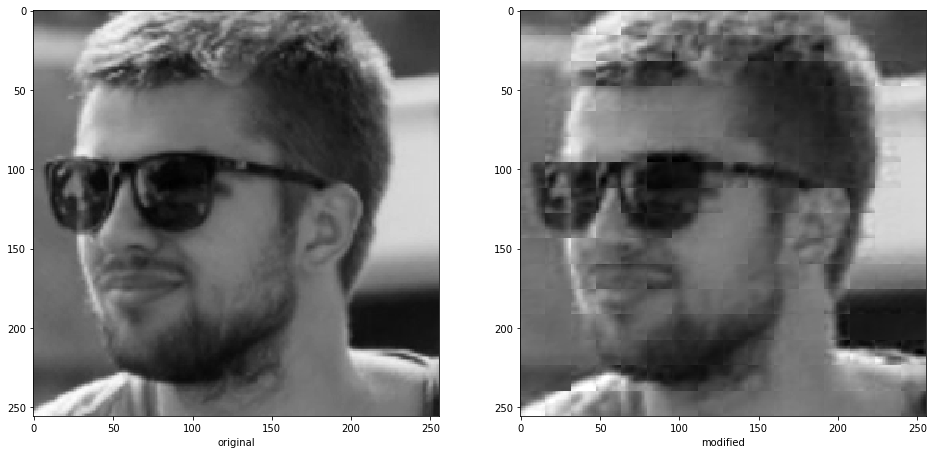

Error:  2223.709228515625
running for alpha=0.1557777777777778
Train on 204 samples, validate on 52 samples
Train begin {}
Epoch 1/500
Epoch: 0 Error: 43917.16015625
Epoch 2/500
Epoch: 1 Error: 25693.125
Epoch 3/500
Epoch: 2 Error: 33721.28515625
Epoch 4/500
Epoch: 3 Error: 18250.724609375
Epoch 5/500
Epoch: 4 Error: 16041.126953125
Epoch 6/500
Epoch: 5 Error: 10686.3359375
Epoch 7/500
Epoch: 6 Error: 9006.28125
Epoch 8/500
Epoch: 7 Error: 7295.66845703125
Epoch 9/500
Epoch: 8 Error: 6482.06640625
Epoch 10/500
Epoch: 9 Error: 6109.619140625
Epoch 11/500
Epoch: 10 Error: 5683.802734375
Epoch 12/500
Epoch: 11 Error: 5515.12158203125
Epoch 13/500
Epoch: 12 Error: 5368.9296875
Epoch 14/500
Epoch: 13 Error: 5219.4794921875
Epoch 15/500
Epoch: 14 Error: 5121.89990234375
Epoch 16/500
Epoch: 15 Error: 5025.123046875
Epoch 17/500
Epoch: 16 Error: 4952.1484375
Epoch 18/500
Epoch: 17 Error: 4855.9716796875
Epoch 19/500
Epoch: 18 Error: 4788.14013671875
Epoch 20/500
Epoch: 19 Error: 4697.001464843

Epoch: 172 Error: 2900.54833984375
Epoch 174/500
Epoch: 173 Error: 2888.16259765625
Epoch 175/500
Epoch: 174 Error: 2874.89013671875
Epoch 176/500
Epoch: 175 Error: 2902.248046875
Epoch 177/500
Epoch: 176 Error: 2881.777099609375
Epoch 178/500
Epoch: 177 Error: 2872.55908203125
Epoch 179/500
Epoch: 178 Error: 2868.96435546875
Epoch 180/500
Epoch: 179 Error: 2856.797607421875
Epoch 181/500
Epoch: 180 Error: 2867.304931640625
Epoch 182/500
Epoch: 181 Error: 2855.282470703125
Epoch 183/500
Epoch: 182 Error: 2867.005126953125
Epoch 184/500
Epoch: 183 Error: 2835.265380859375
Epoch 185/500
Epoch: 184 Error: 2832.66748046875
Epoch 186/500
Epoch: 185 Error: 2863.689453125
Epoch 187/500
Epoch: 186 Error: 2839.774658203125
Epoch 188/500
Epoch: 187 Error: 2840.3671875
Epoch 189/500
Epoch: 188 Error: 2894.203125
Epoch 190/500
Epoch: 189 Error: 2820.176513671875
Epoch 191/500
Epoch: 190 Error: 2831.16748046875
Epoch 192/500
Epoch: 191 Error: 2846.71142578125
Epoch 193/500
Epoch: 192 Error: 2811.73

Epoch: 340 Error: 2391.71875
Epoch 342/500
Epoch: 341 Error: 2372.26025390625
Epoch 343/500
Epoch: 342 Error: 2403.7021484375
Epoch 344/500
Epoch: 343 Error: 2371.50732421875
Epoch 345/500
Epoch: 344 Error: 2386.042724609375
Epoch 346/500
Epoch: 345 Error: 2366.0029296875
Epoch 347/500
Epoch: 346 Error: 2371.263671875
Epoch 348/500
Epoch: 347 Error: 2396.316650390625
Epoch 349/500
Epoch: 348 Error: 2354.517333984375
Epoch 350/500
Epoch: 349 Error: 2385.91796875
Epoch 351/500
Epoch: 350 Error: 2366.35546875
Epoch 352/500
Epoch: 351 Error: 2388.37841796875
Epoch 353/500
Epoch: 352 Error: 2363.441650390625
Epoch 354/500
Epoch: 353 Error: 2371.841064453125
Epoch 355/500
Epoch: 354 Error: 2366.788330078125
Epoch 356/500
Epoch: 355 Error: 2379.32470703125
Epoch 357/500
Epoch: 356 Error: 2363.375732421875
Epoch 358/500
Epoch: 357 Error: 2366.085205078125
Epoch 359/500
Epoch: 358 Error: 2355.310546875
Epoch 360/500
Epoch: 359 Error: 2365.867431640625
Epoch 361/500
Epoch: 360 Error: 2351.871093

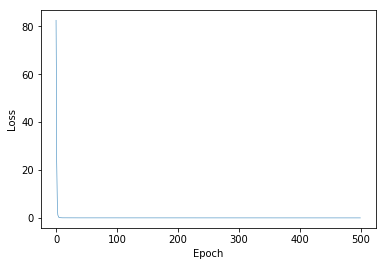

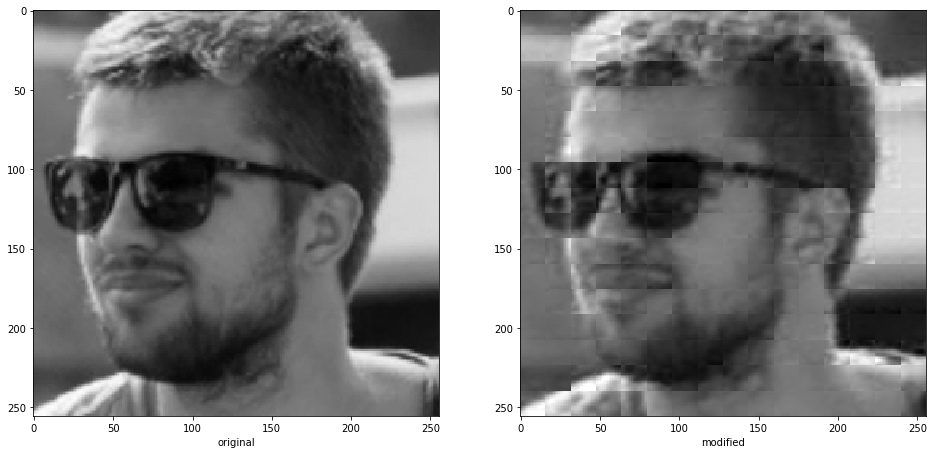

Error:  2283.886962890625
running for alpha=0.13366666666666668
Train on 204 samples, validate on 52 samples
Train begin {}
Epoch 1/500
Epoch: 0 Error: 24138.857421875
Epoch 2/500
Epoch: 1 Error: 24473.591796875
Epoch 3/500
Epoch: 2 Error: 37496.49609375
Epoch 4/500
Epoch: 3 Error: 25792.0078125
Epoch 5/500
Epoch: 4 Error: 15927.9677734375
Epoch 6/500
Epoch: 5 Error: 15026.28125
Epoch 7/500
Epoch: 6 Error: 11570.9580078125
Epoch 8/500
Epoch: 7 Error: 8659.8486328125
Epoch 9/500
Epoch: 8 Error: 8039.0205078125
Epoch 10/500
Epoch: 9 Error: 7144.99609375
Epoch 11/500
Epoch: 10 Error: 6962.4833984375
Epoch 12/500
Epoch: 11 Error: 6457.2109375
Epoch 13/500
Epoch: 12 Error: 6964.06640625
Epoch 14/500
Epoch: 13 Error: 6848.88525390625
Epoch 15/500
Epoch: 14 Error: 6078.35986328125
Epoch 16/500
Epoch: 15 Error: 5607.8486328125
Epoch 17/500
Epoch: 16 Error: 5810.80224609375
Epoch 18/500
Epoch: 17 Error: 5481.283203125
Epoch 19/500
Epoch: 18 Error: 6120.9814453125
Epoch 20/500
Epoch: 19 Error: 5

Epoch: 173 Error: 2831.703125
Epoch 175/500
Epoch: 174 Error: 2708.925537109375
Epoch 176/500
Epoch: 175 Error: 2787.166748046875
Epoch 177/500
Epoch: 176 Error: 2709.5673828125
Epoch 178/500
Epoch: 177 Error: 2973.0673828125
Epoch 179/500
Epoch: 178 Error: 2821.614990234375
Epoch 180/500
Epoch: 179 Error: 2849.075927734375
Epoch 181/500
Epoch: 180 Error: 2784.960205078125
Epoch 182/500
Epoch: 181 Error: 2707.614013671875
Epoch 183/500
Epoch: 182 Error: 2720.029541015625
Epoch 184/500
Epoch: 183 Error: 2678.737060546875
Epoch 185/500
Epoch: 184 Error: 2661.641845703125
Epoch 186/500
Epoch: 185 Error: 2648.88623046875
Epoch 187/500
Epoch: 186 Error: 2654.490234375
Epoch 188/500
Epoch: 187 Error: 2679.43359375
Epoch 189/500
Epoch: 188 Error: 2681.353271484375
Epoch 190/500
Epoch: 189 Error: 2660.108642578125
Epoch 191/500
Epoch: 190 Error: 2631.521484375
Epoch 192/500
Epoch: 191 Error: 2865.4375
Epoch 193/500
Epoch: 192 Error: 2724.7958984375
Epoch 194/500
Epoch: 193 Error: 2641.73266601

Epoch: 343 Error: 2556.693359375
Epoch 345/500
Epoch: 344 Error: 2518.076171875
Epoch 346/500
Epoch: 345 Error: 2464.3369140625
Epoch 347/500
Epoch: 346 Error: 2548.25634765625
Epoch 348/500
Epoch: 347 Error: 2497.341064453125
Epoch 349/500
Epoch: 348 Error: 2623.658203125
Epoch 350/500
Epoch: 349 Error: 2514.239990234375
Epoch 351/500
Epoch: 350 Error: 2513.767822265625
Epoch 352/500
Epoch: 351 Error: 2492.788330078125
Epoch 353/500
Epoch: 352 Error: 2499.84765625
Epoch 354/500
Epoch: 353 Error: 2656.159912109375
Epoch 355/500
Epoch: 354 Error: 3083.797607421875
Epoch 356/500
Epoch: 355 Error: 3360.9892578125
Epoch 357/500
Epoch: 356 Error: 3308.5068359375
Epoch 358/500
Epoch: 357 Error: 2597.2587890625
Epoch 359/500
Epoch: 358 Error: 2552.472412109375
Epoch 360/500
Epoch: 359 Error: 2673.435791015625
Epoch 361/500
Epoch: 360 Error: 2504.88525390625
Epoch 362/500
Epoch: 361 Error: 2445.662109375
Epoch 363/500
Epoch: 362 Error: 2484.871826171875
Epoch 364/500
Epoch: 363 Error: 2436.412

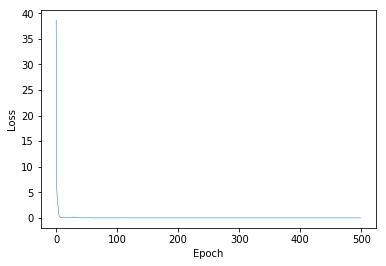

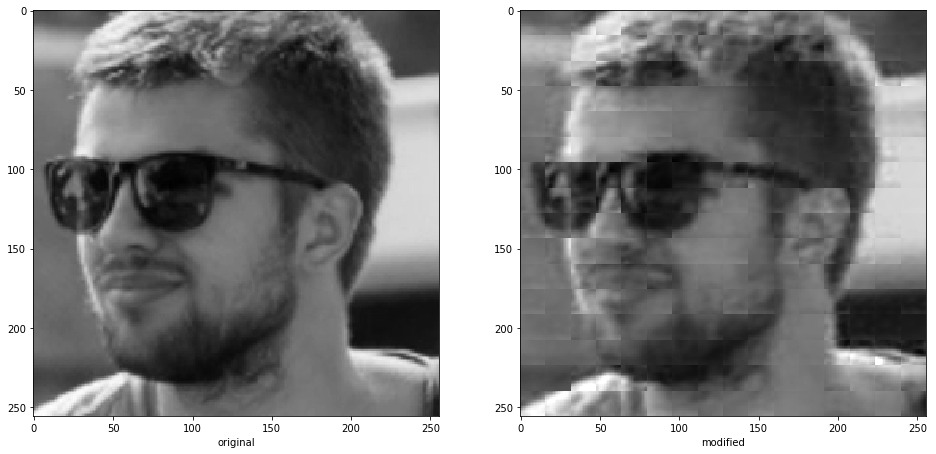

Error:  2242.28173828125
running for alpha=0.11155555555555556
Train on 204 samples, validate on 52 samples
Train begin {}
Epoch 1/500
Epoch: 0 Error: 41906.41796875
Epoch 2/500
Epoch: 1 Error: 22211.603515625
Epoch 3/500
Epoch: 2 Error: 35012.62109375
Epoch 4/500
Epoch: 3 Error: 20336.6484375
Epoch 5/500
Epoch: 4 Error: 13717.9091796875
Epoch 6/500
Epoch: 5 Error: 10513.021484375
Epoch 7/500
Epoch: 6 Error: 8569.0478515625
Epoch 8/500
Epoch: 7 Error: 8776.4873046875
Epoch 9/500
Epoch: 8 Error: 7581.1533203125
Epoch 10/500
Epoch: 9 Error: 6204.55126953125
Epoch 11/500
Epoch: 10 Error: 5769.48876953125
Epoch 12/500
Epoch: 11 Error: 5852.40283203125
Epoch 13/500
Epoch: 12 Error: 5661.7412109375
Epoch 14/500
Epoch: 13 Error: 5574.78759765625
Epoch 15/500
Epoch: 14 Error: 5433.048828125
Epoch 16/500
Epoch: 15 Error: 5899.560546875
Epoch 17/500
Epoch: 16 Error: 5481.90478515625
Epoch 18/500
Epoch: 17 Error: 5202.70751953125
Epoch 19/500
Epoch: 18 Error: 4853.10009765625
Epoch 20/500
Epoch: 

Epoch: 172 Error: 2666.311279296875
Epoch 174/500
Epoch: 173 Error: 2673.203125
Epoch 175/500
Epoch: 174 Error: 2654.444580078125
Epoch 176/500
Epoch: 175 Error: 2652.54443359375
Epoch 177/500
Epoch: 176 Error: 2666.031494140625
Epoch 178/500
Epoch: 177 Error: 2635.071044921875
Epoch 179/500
Epoch: 178 Error: 2653.3291015625
Epoch 180/500
Epoch: 179 Error: 2625.168701171875
Epoch 181/500
Epoch: 180 Error: 2651.12744140625
Epoch 182/500
Epoch: 181 Error: 2627.720703125
Epoch 183/500
Epoch: 182 Error: 2624.1064453125
Epoch 184/500
Epoch: 183 Error: 2628.393310546875
Epoch 185/500
Epoch: 184 Error: 2616.97802734375
Epoch 186/500
Epoch: 185 Error: 2629.513671875
Epoch 187/500
Epoch: 186 Error: 2606.294189453125
Epoch 188/500
Epoch: 187 Error: 2601.017822265625
Epoch 189/500
Epoch: 188 Error: 2609.59814453125
Epoch 190/500
Epoch: 189 Error: 2605.258544921875
Epoch 191/500
Epoch: 190 Error: 2603.511962890625
Epoch 192/500
Epoch: 191 Error: 2582.903076171875
Epoch 193/500
Epoch: 192 Error: 25

Epoch: 340 Error: 2313.998291015625
Epoch 342/500
Epoch: 341 Error: 2297.430419921875
Epoch 343/500
Epoch: 342 Error: 2336.460693359375
Epoch 344/500
Epoch: 343 Error: 2316.200439453125
Epoch 345/500
Epoch: 344 Error: 2366.432373046875
Epoch 346/500
Epoch: 345 Error: 2405.5810546875
Epoch 347/500
Epoch: 346 Error: 2334.52978515625
Epoch 348/500
Epoch: 347 Error: 2459.849853515625
Epoch 349/500
Epoch: 348 Error: 2355.80712890625
Epoch 350/500
Epoch: 349 Error: 2341.060791015625
Epoch 351/500
Epoch: 350 Error: 2345.643310546875
Epoch 352/500
Epoch: 351 Error: 2333.47509765625
Epoch 353/500
Epoch: 352 Error: 2617.950927734375
Epoch 354/500
Epoch: 353 Error: 2702.1904296875
Epoch 355/500
Epoch: 354 Error: 2695.20947265625
Epoch 356/500
Epoch: 355 Error: 2522.072265625
Epoch 357/500
Epoch: 356 Error: 2341.27197265625
Epoch 358/500
Epoch: 357 Error: 2360.748046875
Epoch 359/500
Epoch: 358 Error: 2333.99462890625
Epoch 360/500
Epoch: 359 Error: 2313.203125
Epoch 361/500
Epoch: 360 Error: 2307

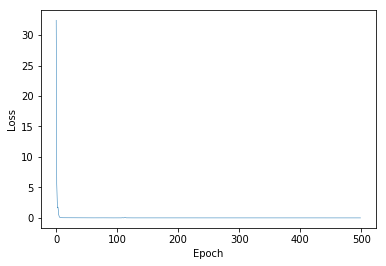

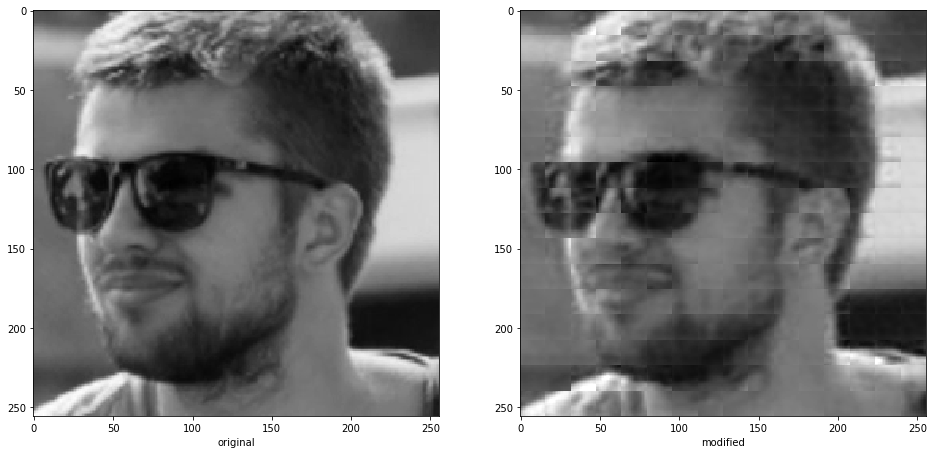

Error:  2174.830322265625
running for alpha=0.08944444444444445
Train on 204 samples, validate on 52 samples
Train begin {}
Epoch 1/500
Epoch: 0 Error: 21283.828125
Epoch 2/500
Epoch: 1 Error: 22390.578125
Epoch 3/500
Epoch: 2 Error: 14020.2763671875
Epoch 4/500
Epoch: 3 Error: 13277.9033203125
Epoch 5/500
Epoch: 4 Error: 7912.76025390625
Epoch 6/500
Epoch: 5 Error: 7851.08154296875
Epoch 7/500
Epoch: 6 Error: 5986.705078125
Epoch 8/500
Epoch: 7 Error: 5586.232421875
Epoch 9/500
Epoch: 8 Error: 5393.89306640625
Epoch 10/500
Epoch: 9 Error: 5101.9091796875
Epoch 11/500
Epoch: 10 Error: 4859.9921875
Epoch 12/500
Epoch: 11 Error: 4465.6435546875
Epoch 13/500
Epoch: 12 Error: 4317.22021484375
Epoch 14/500
Epoch: 13 Error: 4182.5126953125
Epoch 15/500
Epoch: 14 Error: 4087.6865234375
Epoch 16/500
Epoch: 15 Error: 4005.226318359375
Epoch 17/500
Epoch: 16 Error: 3992.26904296875
Epoch 18/500
Epoch: 17 Error: 3913.2275390625
Epoch 19/500
Epoch: 18 Error: 3897.186767578125
Epoch 20/500
Epoch: 1

Epoch: 171 Error: 2401.16357421875
Epoch 173/500
Epoch: 172 Error: 2394.6083984375
Epoch 174/500
Epoch: 173 Error: 2411.111572265625
Epoch 175/500
Epoch: 174 Error: 2407.27001953125
Epoch 176/500
Epoch: 175 Error: 2393.24951171875
Epoch 177/500
Epoch: 176 Error: 2427.951171875
Epoch 178/500
Epoch: 177 Error: 2459.448974609375
Epoch 179/500
Epoch: 178 Error: 2487.786865234375
Epoch 180/500
Epoch: 179 Error: 2434.4501953125
Epoch 181/500
Epoch: 180 Error: 2487.638427734375
Epoch 182/500
Epoch: 181 Error: 2416.1826171875
Epoch 183/500
Epoch: 182 Error: 2390.709228515625
Epoch 184/500
Epoch: 183 Error: 2399.130126953125
Epoch 185/500
Epoch: 184 Error: 2385.02587890625
Epoch 186/500
Epoch: 185 Error: 2366.502197265625
Epoch 187/500
Epoch: 186 Error: 2353.81005859375
Epoch 188/500
Epoch: 187 Error: 2355.3955078125
Epoch 189/500
Epoch: 188 Error: 2361.0302734375
Epoch 190/500
Epoch: 189 Error: 2372.96240234375
Epoch 191/500
Epoch: 190 Error: 2368.148681640625
Epoch 192/500
Epoch: 191 Error: 2

Epoch: 339 Error: 2150.24072265625
Epoch 341/500
Epoch: 340 Error: 2155.621826171875
Epoch 342/500
Epoch: 341 Error: 2120.891845703125
Epoch 343/500
Epoch: 342 Error: 2162.555419921875
Epoch 344/500
Epoch: 343 Error: 2138.701416015625
Epoch 345/500
Epoch: 344 Error: 2120.41015625
Epoch 346/500
Epoch: 345 Error: 2137.80859375
Epoch 347/500
Epoch: 346 Error: 2121.58349609375
Epoch 348/500
Epoch: 347 Error: 2163.760009765625
Epoch 349/500
Epoch: 348 Error: 2132.95068359375
Epoch 350/500
Epoch: 349 Error: 2133.430908203125
Epoch 351/500
Epoch: 350 Error: 2156.444091796875
Epoch 352/500
Epoch: 351 Error: 2120.8828125
Epoch 353/500
Epoch: 352 Error: 2147.80224609375
Epoch 354/500
Epoch: 353 Error: 2116.9443359375
Epoch 355/500
Epoch: 354 Error: 2145.060791015625
Epoch 356/500
Epoch: 355 Error: 2145.513427734375
Epoch 357/500
Epoch: 356 Error: 2120.25146484375
Epoch 358/500
Epoch: 357 Error: 2206.10693359375
Epoch 359/500
Epoch: 358 Error: 2201.7177734375
Epoch 360/500
Epoch: 359 Error: 2155.

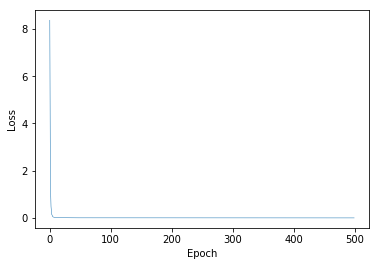

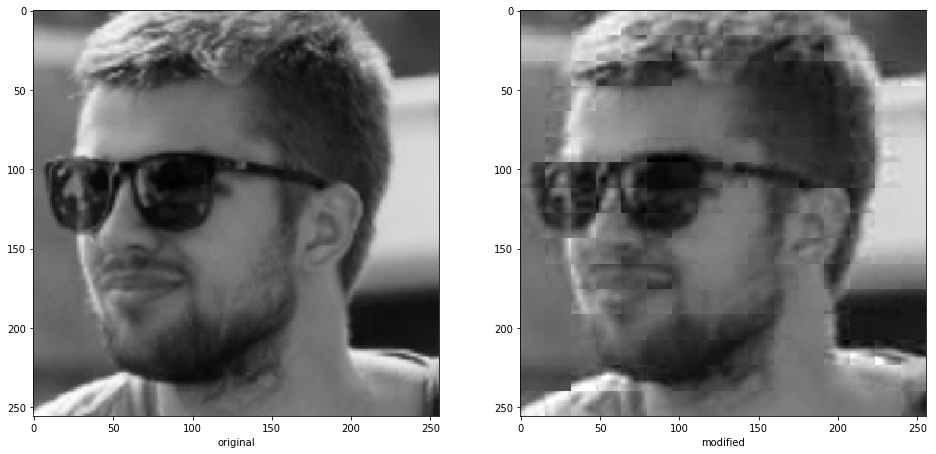

Error:  2094.955810546875
running for alpha=0.06733333333333334
Train on 204 samples, validate on 52 samples
Train begin {}
Epoch 1/500
Epoch: 0 Error: 18209.359375
Epoch 2/500
Epoch: 1 Error: 16394.525390625
Epoch 3/500
Epoch: 2 Error: 9925.78125
Epoch 4/500
Epoch: 3 Error: 8478.5498046875
Epoch 5/500
Epoch: 4 Error: 6940.94677734375
Epoch 6/500
Epoch: 5 Error: 5856.84228515625
Epoch 7/500
Epoch: 6 Error: 5360.85205078125
Epoch 8/500
Epoch: 7 Error: 4842.85498046875
Epoch 9/500
Epoch: 8 Error: 4507.626953125
Epoch 10/500
Epoch: 9 Error: 4370.9326171875
Epoch 11/500
Epoch: 10 Error: 4478.41162109375
Epoch 12/500
Epoch: 11 Error: 4184.27490234375
Epoch 13/500
Epoch: 12 Error: 3984.567138671875
Epoch 14/500
Epoch: 13 Error: 3893.255126953125
Epoch 15/500
Epoch: 14 Error: 3900.3193359375
Epoch 16/500
Epoch: 15 Error: 4440.388671875
Epoch 17/500
Epoch: 16 Error: 5833.98095703125
Epoch 18/500
Epoch: 17 Error: 7011.00439453125
Epoch 19/500
Epoch: 18 Error: 4406.23193359375
Epoch 20/500
Epoch

Epoch: 170 Error: 2276.61328125
Epoch 172/500
Epoch: 171 Error: 2299.6806640625
Epoch 173/500
Epoch: 172 Error: 2300.8271484375
Epoch 174/500
Epoch: 173 Error: 2295.62841796875
Epoch 175/500
Epoch: 174 Error: 2283.77587890625
Epoch 176/500
Epoch: 175 Error: 2298.19287109375
Epoch 177/500
Epoch: 176 Error: 2289.251708984375
Epoch 178/500
Epoch: 177 Error: 2276.266357421875
Epoch 179/500
Epoch: 178 Error: 2286.677490234375
Epoch 180/500
Epoch: 179 Error: 2293.540283203125
Epoch 181/500
Epoch: 180 Error: 2288.12939453125
Epoch 182/500
Epoch: 181 Error: 2296.53271484375
Epoch 183/500
Epoch: 182 Error: 2261.983154296875
Epoch 184/500
Epoch: 183 Error: 2290.050537109375
Epoch 185/500
Epoch: 184 Error: 2295.704833984375
Epoch 186/500
Epoch: 185 Error: 2288.679931640625
Epoch 187/500
Epoch: 186 Error: 2268.88916015625
Epoch 188/500
Epoch: 187 Error: 2279.5537109375
Epoch 189/500
Epoch: 188 Error: 2269.203125
Epoch 190/500
Epoch: 189 Error: 2292.089111328125
Epoch 191/500
Epoch: 190 Error: 2280

Epoch: 340 Error: 2205.405517578125
Epoch 342/500
Epoch: 341 Error: 2205.72412109375
Epoch 343/500
Epoch: 342 Error: 2136.0302734375
Epoch 344/500
Epoch: 343 Error: 2147.910888671875
Epoch 345/500
Epoch: 344 Error: 2181.5517578125
Epoch 346/500
Epoch: 345 Error: 2156.723388671875
Epoch 347/500
Epoch: 346 Error: 2181.68896484375
Epoch 348/500
Epoch: 347 Error: 2164.6630859375
Epoch 349/500
Epoch: 348 Error: 2150.77734375
Epoch 350/500
Epoch: 349 Error: 2126.336669921875
Epoch 351/500
Epoch: 350 Error: 2142.61376953125
Epoch 352/500
Epoch: 351 Error: 2139.4970703125
Epoch 353/500
Epoch: 352 Error: 2105.95556640625
Epoch 354/500
Epoch: 353 Error: 2150.941650390625
Epoch 355/500
Epoch: 354 Error: 2187.000244140625
Epoch 356/500
Epoch: 355 Error: 2188.33740234375
Epoch 357/500
Epoch: 356 Error: 2170.4765625
Epoch 358/500
Epoch: 357 Error: 2146.4443359375
Epoch 359/500
Epoch: 358 Error: 2145.724609375
Epoch 360/500
Epoch: 359 Error: 2118.410888671875
Epoch 361/500
Epoch: 360 Error: 2209.3947

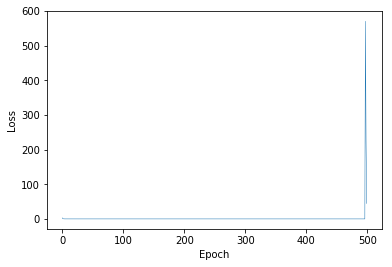

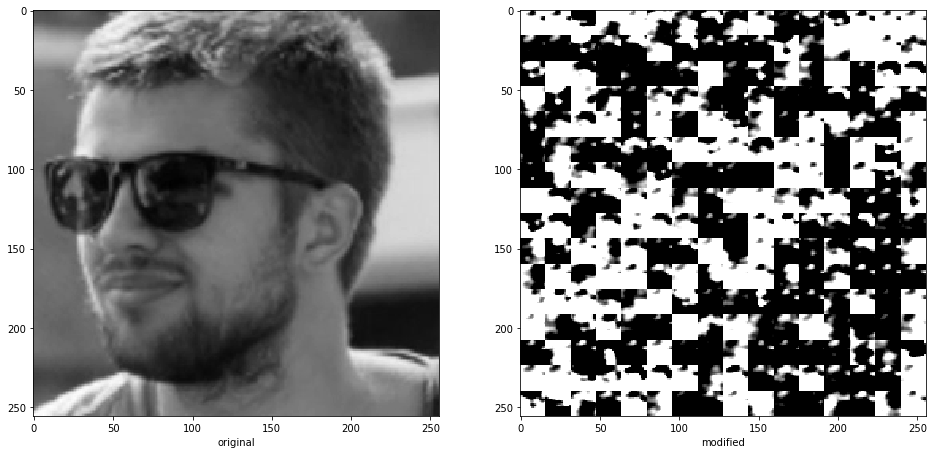

Error:  2105.95556640625
running for alpha=0.045222222222222226
Train on 204 samples, validate on 52 samples
Train begin {}
Epoch 1/500
Epoch: 0 Error: 18941.5
Epoch 2/500
Epoch: 1 Error: 10259.0546875
Epoch 3/500
Epoch: 2 Error: 7829.802734375
Epoch 4/500
Epoch: 3 Error: 6615.47265625
Epoch 5/500
Epoch: 4 Error: 5721.6279296875
Epoch 6/500
Epoch: 5 Error: 4557.7724609375
Epoch 7/500
Epoch: 6 Error: 4258.90771484375
Epoch 8/500
Epoch: 7 Error: 3963.328125
Epoch 9/500
Epoch: 8 Error: 3808.527099609375
Epoch 10/500
Epoch: 9 Error: 3665.130859375
Epoch 11/500
Epoch: 10 Error: 3614.172119140625
Epoch 12/500
Epoch: 11 Error: 3504.5380859375
Epoch 13/500
Epoch: 12 Error: 3415.863525390625
Epoch 14/500
Epoch: 13 Error: 3335.4580078125
Epoch 15/500
Epoch: 14 Error: 3251.34765625
Epoch 16/500
Epoch: 15 Error: 3179.293212890625
Epoch 17/500
Epoch: 16 Error: 3124.922607421875
Epoch 18/500
Epoch: 17 Error: 3072.626953125
Epoch 19/500
Epoch: 18 Error: 3035.436767578125
Epoch 20/500
Epoch: 19 Error:

Epoch: 170 Error: 2258.922119140625
Epoch 172/500
Epoch: 171 Error: 2263.760986328125
Epoch 173/500
Epoch: 172 Error: 2246.01806640625
Epoch 174/500
Epoch: 173 Error: 2221.84033203125
Epoch 175/500
Epoch: 174 Error: 2263.7568359375
Epoch 176/500
Epoch: 175 Error: 2228.5
Epoch 177/500
Epoch: 176 Error: 2238.613525390625
Epoch 178/500
Epoch: 177 Error: 2254.72607421875
Epoch 179/500
Epoch: 178 Error: 2243.996826171875
Epoch 180/500
Epoch: 179 Error: 2256.109619140625
Epoch 181/500
Epoch: 180 Error: 2310.94287109375
Epoch 182/500
Epoch: 181 Error: 2281.181640625
Epoch 183/500
Epoch: 182 Error: 2245.73681640625
Epoch 184/500
Epoch: 183 Error: 2226.546142578125
Epoch 185/500
Epoch: 184 Error: 2207.4453125
Epoch 186/500
Epoch: 185 Error: 2258.4814453125
Epoch 187/500
Epoch: 186 Error: 2220.323486328125
Epoch 188/500
Epoch: 187 Error: 2227.189208984375
Epoch 189/500
Epoch: 188 Error: 2225.43505859375
Epoch 190/500
Epoch: 189 Error: 2209.489990234375
Epoch 191/500
Epoch: 190 Error: 2247.993896

Epoch: 338 Error: 2188.359130859375
Epoch 340/500
Epoch: 339 Error: 2160.90625
Epoch 341/500
Epoch: 340 Error: 2196.195068359375
Epoch 342/500
Epoch: 341 Error: 2513.26318359375
Epoch 343/500
Epoch: 342 Error: 2272.459716796875
Epoch 344/500
Epoch: 343 Error: 2276.703125
Epoch 345/500
Epoch: 344 Error: 2262.165771484375
Epoch 346/500
Epoch: 345 Error: 2352.342041015625
Epoch 347/500
Epoch: 346 Error: 2306.45361328125
Epoch 348/500
Epoch: 347 Error: 2253.255615234375
Epoch 349/500
Epoch: 348 Error: 2244.52490234375
Epoch 350/500
Epoch: 349 Error: 2218.786865234375
Epoch 351/500
Epoch: 350 Error: 2144.01904296875
Epoch 352/500
Epoch: 351 Error: 2230.80908203125
Epoch 353/500
Epoch: 352 Error: 2309.773193359375
Epoch 354/500
Epoch: 353 Error: 2260.774169921875
Epoch 355/500
Epoch: 354 Error: 2327.757080078125
Epoch 356/500
Epoch: 355 Error: 2329.80224609375
Epoch 357/500
Epoch: 356 Error: 2283.857666015625
Epoch 358/500
Epoch: 357 Error: 2275.179931640625
Epoch 359/500
Epoch: 358 Error: 2

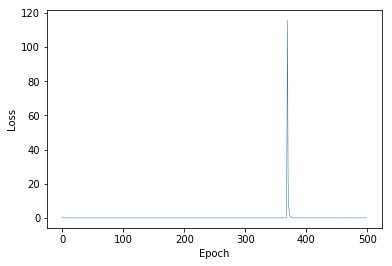

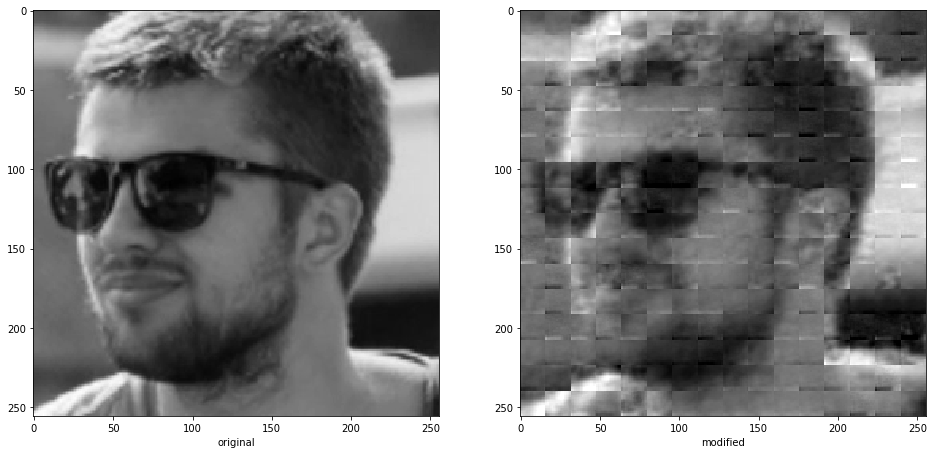

Error:  2101.34228515625
running for alpha=0.023111111111111114
Train on 204 samples, validate on 52 samples
Train begin {}
Epoch 1/500
Epoch: 0 Error: 9186.3916015625
Epoch 2/500
Epoch: 1 Error: 6520.7880859375
Epoch 3/500
Epoch: 2 Error: 5243.505859375
Epoch 4/500
Epoch: 3 Error: 4249.33056640625
Epoch 5/500
Epoch: 4 Error: 3926.937255859375
Epoch 6/500
Epoch: 5 Error: 3797.625732421875
Epoch 7/500
Epoch: 6 Error: 3685.00927734375
Epoch 8/500
Epoch: 7 Error: 3566.54150390625
Epoch 9/500
Epoch: 8 Error: 3490.694091796875
Epoch 10/500
Epoch: 9 Error: 3369.31982421875
Epoch 11/500
Epoch: 10 Error: 3349.653076171875
Epoch 12/500
Epoch: 11 Error: 3454.652099609375
Epoch 13/500
Epoch: 12 Error: 3305.55859375
Epoch 14/500
Epoch: 13 Error: 3153.126953125
Epoch 15/500
Epoch: 14 Error: 3170.39013671875
Epoch 16/500
Epoch: 15 Error: 2970.546630859375
Epoch 17/500
Epoch: 16 Error: 2943.300048828125
Epoch 18/500
Epoch: 17 Error: 2870.044921875
Epoch 19/500
Epoch: 18 Error: 2847.0673828125
Epoch 2

Epoch: 169 Error: 2181.5185546875
Epoch 171/500
Epoch: 170 Error: 2098.556884765625
Epoch 172/500
Epoch: 171 Error: 2171.23681640625
Epoch 173/500
Epoch: 172 Error: 2118.126953125
Epoch 174/500
Epoch: 173 Error: 2140.89501953125
Epoch 175/500
Epoch: 174 Error: 2309.285400390625
Epoch 176/500
Epoch: 175 Error: 2205.756591796875
Epoch 177/500
Epoch: 176 Error: 2218.385498046875
Epoch 178/500
Epoch: 177 Error: 2223.715087890625
Epoch 179/500
Epoch: 178 Error: 2125.412841796875
Epoch 180/500
Epoch: 179 Error: 2132.13916015625
Epoch 181/500
Epoch: 180 Error: 2166.292236328125
Epoch 182/500
Epoch: 181 Error: 2102.61669921875
Epoch 183/500
Epoch: 182 Error: 2135.90380859375
Epoch 184/500
Epoch: 183 Error: 2133.418701171875
Epoch 185/500
Epoch: 184 Error: 2135.949462890625
Epoch 186/500
Epoch: 185 Error: 2206.99853515625
Epoch 187/500
Epoch: 186 Error: 2190.73388671875
Epoch 188/500
Epoch: 187 Error: 2137.260498046875
Epoch 189/500
Epoch: 188 Error: 2149.904541015625
Epoch 190/500
Epoch: 189 E

Epoch: 337 Error: 2296.936279296875
Epoch 339/500
Epoch: 338 Error: 2244.1923828125
Epoch 340/500
Epoch: 339 Error: 2199.42236328125
Epoch 341/500
Epoch: 340 Error: 2182.916259765625
Epoch 342/500
Epoch: 341 Error: 2222.588623046875
Epoch 343/500
Epoch: 342 Error: 2140.03125
Epoch 344/500
Epoch: 343 Error: 2220.519287109375
Epoch 345/500
Epoch: 344 Error: 2188.005126953125
Epoch 346/500
Epoch: 345 Error: 2403.322998046875
Epoch 347/500
Epoch: 346 Error: 2226.830810546875
Epoch 348/500
Epoch: 347 Error: 2182.926513671875
Epoch 349/500
Epoch: 348 Error: 2231.321044921875
Epoch 350/500
Epoch: 349 Error: 2278.77392578125
Epoch 351/500
Epoch: 350 Error: 2259.53466796875
Epoch 352/500
Epoch: 351 Error: 2167.844482421875
Epoch 353/500
Epoch: 352 Error: 2286.833740234375
Epoch 354/500
Epoch: 353 Error: 2260.18798828125
Epoch 355/500
Epoch: 354 Error: 2279.269287109375
Epoch 356/500
Epoch: 355 Error: 2208.739013671875
Epoch 357/500
Epoch: 356 Error: 2309.664306640625
Epoch 358/500
Epoch: 357 Er

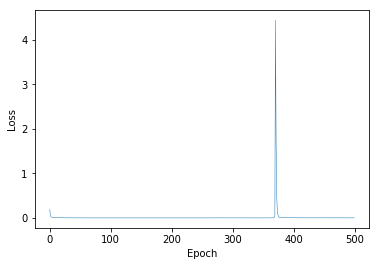

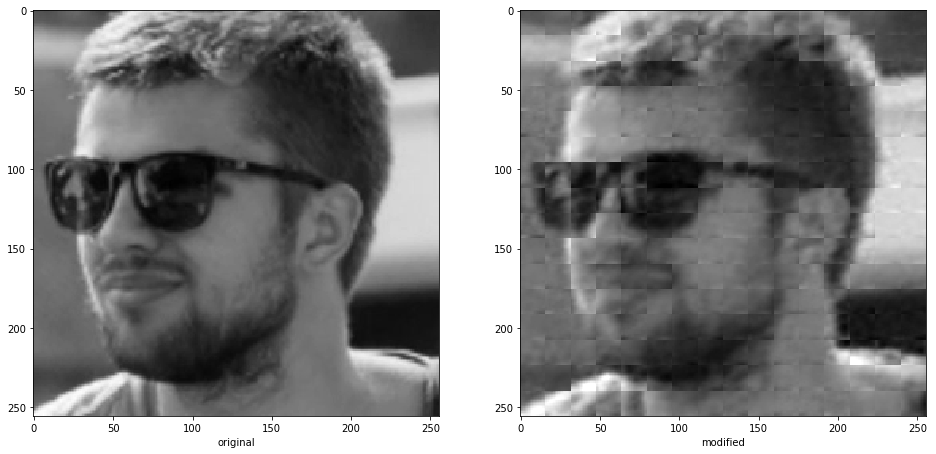

Error:  2098.556884765625
running for alpha=0.001
Train on 204 samples, validate on 52 samples
Train begin {}
Epoch 1/500
Epoch: 0 Error: 13901.900390625
Epoch 2/500
Epoch: 1 Error: 12507.4375
Epoch 3/500
Epoch: 2 Error: 10656.248046875
Epoch 4/500
Epoch: 3 Error: 8921.220703125
Epoch 5/500
Epoch: 4 Error: 7720.02294921875
Epoch 6/500
Epoch: 5 Error: 7033.939453125
Epoch 7/500
Epoch: 6 Error: 6635.69580078125
Epoch 8/500
Epoch: 7 Error: 6366.67919921875
Epoch 9/500
Epoch: 8 Error: 6210.81982421875
Epoch 10/500
Epoch: 9 Error: 6064.5166015625
Epoch 11/500
Epoch: 10 Error: 5926.92041015625
Epoch 12/500
Epoch: 11 Error: 5808.01220703125
Epoch 13/500
Epoch: 12 Error: 5667.185546875
Epoch 14/500
Epoch: 13 Error: 5514.671875
Epoch 15/500
Epoch: 14 Error: 5344.71484375
Epoch 16/500
Epoch: 15 Error: 5182.9990234375
Epoch 17/500
Epoch: 16 Error: 5021.0859375
Epoch 18/500
Epoch: 17 Error: 4849.7744140625
Epoch 19/500
Epoch: 18 Error: 4695.0732421875
Epoch 20/500
Epoch: 19 Error: 4573.5595703125


Epoch: 171 Error: 2615.8251953125
Epoch 173/500
Epoch: 172 Error: 2613.705810546875
Epoch 174/500
Epoch: 173 Error: 2607.771484375
Epoch 175/500
Epoch: 174 Error: 2603.069580078125
Epoch 176/500
Epoch: 175 Error: 2601.62646484375
Epoch 177/500
Epoch: 176 Error: 2584.837646484375
Epoch 178/500
Epoch: 177 Error: 2595.39208984375
Epoch 179/500
Epoch: 178 Error: 2585.656005859375
Epoch 180/500
Epoch: 179 Error: 2573.715576171875
Epoch 181/500
Epoch: 180 Error: 2580.712890625
Epoch 182/500
Epoch: 181 Error: 2572.6796875
Epoch 183/500
Epoch: 182 Error: 2569.6650390625
Epoch 184/500
Epoch: 183 Error: 2561.451171875
Epoch 185/500
Epoch: 184 Error: 2566.53857421875
Epoch 186/500
Epoch: 185 Error: 2554.627685546875
Epoch 187/500
Epoch: 186 Error: 2551.513671875
Epoch 188/500
Epoch: 187 Error: 2546.2158203125
Epoch 189/500
Epoch: 188 Error: 2546.28857421875
Epoch 190/500
Epoch: 189 Error: 2537.94091796875
Epoch 191/500
Epoch: 190 Error: 2541.587646484375
Epoch 192/500
Epoch: 191 Error: 2538.18896

Epoch: 340 Error: 2199.58642578125
Epoch 342/500
Epoch: 341 Error: 2195.47900390625
Epoch 343/500
Epoch: 342 Error: 2199.94287109375
Epoch 344/500
Epoch: 343 Error: 2199.405029296875
Epoch 345/500
Epoch: 344 Error: 2205.8623046875
Epoch 346/500
Epoch: 345 Error: 2200.7822265625
Epoch 347/500
Epoch: 346 Error: 2203.0009765625
Epoch 348/500
Epoch: 347 Error: 2195.25732421875
Epoch 349/500
Epoch: 348 Error: 2201.480224609375
Epoch 350/500
Epoch: 349 Error: 2193.6298828125
Epoch 351/500
Epoch: 350 Error: 2195.4326171875
Epoch 352/500
Epoch: 351 Error: 2201.326416015625
Epoch 353/500
Epoch: 352 Error: 2197.026611328125
Epoch 354/500
Epoch: 353 Error: 2191.85888671875
Epoch 355/500
Epoch: 354 Error: 2190.868896484375
Epoch 356/500
Epoch: 355 Error: 2197.2109375
Epoch 357/500
Epoch: 356 Error: 2191.205078125
Epoch 358/500
Epoch: 357 Error: 2199.516845703125
Epoch 359/500
Epoch: 358 Error: 2196.23828125
Epoch 360/500
Epoch: 359 Error: 2191.16259765625
Epoch 361/500
Epoch: 360 Error: 2194.84594

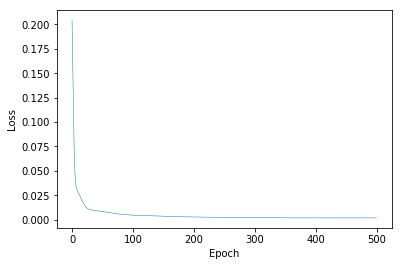

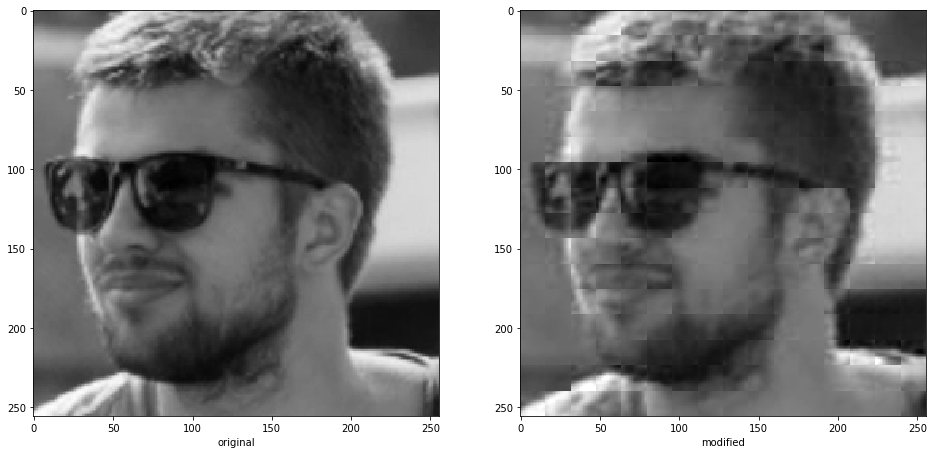

Error:  2183.739013671875


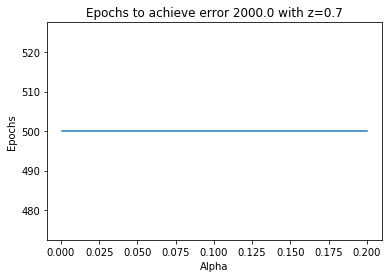

In [502]:
N_alpha = 10
alphas = np.linspace(1e-3, 0.2, N_alpha)
MAX_EPOCHS = 500
Z = 0.7
TH_ERR = 2000.0
epochs = np.array([])
for alpha in alphas[::-1]:
    print('running for alpha={}'.format(alpha))
    model = Autoencoder(input_layers=N, z=z, lr=alpha, max_epochs=MAX_EPOCHS, dynamic_lr=False, min_error=TH_ERR)
#     model = Autoencoder(input_layers=N, z=Z, lr=alpha, dynamic_lr=False)
    best_results = try_run(model)
    epochs = np.append(epochs, best_results['epoch'])
    print('Error: ', best_results['min_err'])
    
plt.plot(alphas[::-1], epochs)
plt.title('Epochs to achieve error {} with z={}'.format(TH_ERR, Z))
plt.xlabel('Alpha')
plt.ylabel('Epochs')
plt.show()